# E-89 Final Project Code

#### Andrew Merz

### Topic:  Predicting Heart Attack (Myocardial Infarction) Incidence in the Health and Retirement Survey (HRS)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from keras import optimizers
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Read data that was joined and processed by "Retrieve and Join Data.ipynb"
numeric_cols = [
    'XC040', 'XC257', 'XC258', 'XC259', 'YC040', 'YC257', 'YC258', 'YC259', 'ZC040', 'ZC257', 'ZC258', 
    'ZC259', '2010_age', 'heart_attack'
]
df2 = pd.read_csv('full_joined_data.csv')
conv_map = dict([[col, str] for col in df2.columns if col not in numeric_cols])
df2 = pd.read_csv('full_joined_data.csv', dtype=conv_map)
print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20376 entries, 0 to 20375
Columns: 770 entries, HHID to MN365
dtypes: int64(2), object(768)
memory usage: 119.7+ MB
None


,HHID,LSUBHH_x,MC001,MC002,MC005,MC006,MC008,MC009,MC010,MC011,...,LC040,LC045,KC141,KC142,KC139,KC040,KC045,MB082,MN360,MN365
0,000003,0,3,3,5,,,,5,,...,5,5,5,04,158,5,5,2,1,5
1,000003,0,4,3,5,,,,5,,...,,,5,04,144,,,1,5,5
2,010001,0,3,2,5,,,,5,,...,,,6,00,160,,,5,1,5
3,010003,0,3,1,1,1,1,1,5,,...,5,5,5,02,130,,,4,1,1
4,010004,0,4,2,1,1,1,2,5,,...,,,6,01,226,,,3,1,1


Recode the selected variables of interest into a format where we can easily visualize their relationship with the outcome (having a heart attack in the period 2010).  This recode is not the final format that will be used in the deep learning model, but rather, it recodes the data into strings so we can easily see what each of the proportions/distributions mean (see below).

In [3]:
# Returns new dataset with response variable and recoded predictor variables
# "Don't know" and "Refused" responses are recoded as NaN
def select_and_recode(df):
    output = df[['heart_attack']]
    
    # Demographic variables
    output['gender'] = df['GENDER'].map({'1': 'male', '2': 'female', '': None})
    output['hispanic'] = df['HISPANIC'].map({'0': None, '1': 'hispanic', '2': 'hispanic', '3': 'hispanic', '5': 'non-hispanic'})
    output['race'] = df['RACE'].map({'0': None, '1': 'white', '2': 'black', '7': 'other'})
    output['age'] = pd.to_numeric(df['MAGE'])
    output['school_yrs'] = [int(v) if v != '99' else None for v in df['SCHLYRS']]
    output['marital_status'] = df['MMARST'].map({'1': 'married', '2': 'separated/divorced', '3': 'widowed', '4': 'never married', '5': None})
    liv_stat_map = {
        '1': 'mop, lwp', #'Married or partnered, living with partner',
        '2': 'mop, nwlp', #'Married or partnered, not living with spouse/partner',
        '3': 'nmop, lwua', #'Not married or partnered, living with other unrelated adult',
        '4': 'nmop, lwr', #'Not married or partnered, living with relative (including minor children), or unrelated minor child',
        '5': 'nmop, la', #'Not married or partnered, living alone',
        '6': None
    }
    output['living_status'] = df['MLIVARR'].map(liv_stat_map)
    attend_freq_map = {
        '1': 'more than once a week',
        '2': 'once a week',
        '3': 'two or three times a month',
        '4': 'one or more times a year',
        '5': 'not at all',
        '8': None,
        '9': None
    }
    output['attend_freq'] = df['MB082'].map(attend_freq_map)
    
    
    BP_map = {
        '1': 'high', 
        '3': 'high', 
        '4': 'not high', 
        '5': 'not high'
    }
    output['blood_pressure'] = df['MC005'].map(BP_map)
    
    # Compute BMI = kg/m**2
    output['height_sr10_ft'] = [int(v) if v not in ['', '8', '9'] else None for v in df['MC141'].str.replace('\s+', '')]
    output['height_sr10_in'] = [float(v) if v not in ['', '99998.00', '99999.00'] else None for v in df['MC142'].str.replace('\s+', '')]
    output['height_sr10'] = output['height_sr10_ft'] * 12 + output['height_sr10_in']
    output['height_sr08_ft'] = [int(v) if v not in ['', '8', '9'] else None for v in df['LC141'].str.replace('\s+', '').fillna('')]
    output['height_sr08_in'] = [float(v) if v not in ['', '99998.00', '99999.00'] else None for v in df['LC142'].str.replace('\s+', '').fillna('')]
    output['height_sr08'] = output['height_sr08_ft'] * 12 + output['height_sr08_in']
    output['height_sr06_ft'] = [int(v) if v not in ['', '8', '9'] else None for v in df['KC141'].str.replace('\s+', '').fillna('')]
    output['height_sr06_in'] = [float(v) if v not in ['', '99998.00', '99999.00'] else None for v in df['KC142'].str.replace('\s+', '').fillna('')]
    output['height_sr06'] = output['height_sr06_ft'] * 12 + output['height_sr06_in']
    
    output['height_m10'] = pd.Series([float(v) if v not in ['', '99998.00', '99999.00'] else None for v in df['MI834'].str.replace('\s+', '').fillna('')])
    output['height_m08'] = pd.Series([float(v) if v not in ['', '99998.00', '99999.00'] else None for v in df['LI834'].str.replace('\s+', '').fillna('')])
    output['height_m06'] = pd.Series([float(v) if v not in ['', '99998.00', '99999.00'] else None for v in df['KI834'].str.replace('\s+', '').fillna('')])

    height_in = []
    height_source = []
    for r in output.to_dict('records'):
        if str(r['height_m10']) != 'nan' and r['height_m10'] <= 96 and r['height_m10'] >= 36:
            height_in.append(r['height_m10'])
            height_source.append('2010 Measured')
        elif str(r['height_m08']) != 'nan' and r['height_m08'] <= 96 and r['height_m08'] >= 36:
            height_in.append(r['height_m08'])
            height_source.append('2008 Measured')
        elif str(r['height_m06']) != 'nan' and r['height_m06'] <= 96 and r['height_m06'] >= 36:
            height_in.append(r['height_m06'])
            height_source.append('2006 Measured')
        elif str(r['height_sr10']) != 'nan' and r['height_sr10'] <= 96 and r['height_sr10'] >= 36:
            height_in.append(r['height_sr10'])
            height_source.append('2010 Self-Report')
        elif str(r['height_sr08']) != 'nan' and r['height_sr08'] <= 96 and r['height_sr08'] >= 36:
            height_in.append(r['height_sr08'])
            height_source.append('2008 Self-Report')
        elif str(r['height_sr06']) != 'nan' and r['height_sr06'] <= 96 and r['height_sr06'] >= 36:
            height_in.append(r['height_sr06'])
            height_source.append('2006 Self-Report')
        else:
            height_in.append(None)
            height_source.append(None)

    output['height_in'] = height_in
    output['height_source'] = height_source
    output['weight_lbs'] = [int(v) if v not in ['', '998', '999'] else None for v in df['MC139'].str.replace('\s+', '')]
    output['bmi'] = 0.453592 * output['weight_lbs'] / (output['height_in'] * 0.0254)**2
    bmi_cat = []
    for r in output.to_dict('records'):
        if str(r['bmi']) == 'nan':
            bmi_cat.append(None)
        elif r['bmi'] < 18.5:
            bmi_cat.append('underweight')
        elif r['bmi'] >= 18.5 and r['bmi'] < 25:
            bmi_cat.append('normal')
        elif r['bmi'] >= 25 and r['bmi'] < 30:
            bmi_cat.append('overweight')
        elif r['bmi'] >= 30 and r['bmi'] < 40:
            bmi_cat.append('obese')
        else:
            bmi_cat.append('extremely obese')
    output['bmi_cat'] = bmi_cat

    diabetes = []
    for r in df.to_dict('records'):
        if r['MC010'] in ['1', '3'] and (r['MC011'] == '1' or r['MC012'] == '1' or r['MC015'] == '5' or r['MC016'] == '3'):
            diabetes.append('active')
        elif r['MC010'] in ['1', '3']:
            diabetes.append('inactive')
        elif r['MC010'] in ['4', '5']:
            diabetes.append('never had')
        else:
            diabetes.append(None)
    output['diabetes'] = diabetes
    
    # warning:  this is not capturing NaNs!
    output['metabolic_syndrome'] = (output['blood_pressure'] == 'high') & (output['bmi'] >= 30) & (output['diabetes'] == 'active')

    cancer = []
    for i in range(len(df)):
        if df['MC018'][i] in ['1', '3'] and df['MC020'][i] == '1':
            cancer.append('active')
        elif df['MC018'][i] in ['1', '3']:
            cancer.append('cured/remission')
        elif df['MC018'][i] in ['4', '5']:
            cancer.append('never had')
        else:
            cancer.append(None)
    output['cancer'] = cancer

    lung_disease = []
    for i in range(len(df)):
        if df['MC030'][i] in ['1', '3'] and (df['MC031'][i] == '3' or df['MC032'][i] == '1' or df['MC033'][i] == '1' or df['MC034'][i] == '1' or df['MC035'][i] == '1'):
            lung_disease.append('active')
        elif df['MC030'][i] in ['1', '3']:
            lung_disease.append('cured/remission')
        elif df['MC030'][i] in ['4', '5']:
            lung_disease.append('never had')
        else:
            lung_disease.append(None)
    output['lung_disease'] = lung_disease
    
    HA_past_6_yrs = []
    for i in range(len(df)):
        if df['MC257'][i] == '1' and ((float(df['MC258'][i]) >= 2004 and float(df['MC258'][i]) <= 2010) or (df['MC274'][i] == '1' and float(df['MC275'][i]) >= 2004 and float(df['MC276'][i]) <= 2010)):
            HA_past_6_yrs.append('yes')
        elif df['MC040'][i] == '1' or df['LC040'][i] == '1' or df['KC040'][i] == '1':
            HA_past_6_yrs.append('yes')
        elif df['MC257'][i] in ['8', '9'] or df['MC040'][i] in ['8', '9'] or df['LC040'][i] in ['8', '9'] or df['KC040'][i] in ['8', '9']:
            HA_past_6_yrs.append(None)
        elif df['MC257'][i] == '5' or df['MC040'][i] == '5' or df['LC040'][i] == '5' or df['KC040'][i] == '5':
            HA_past_6_yrs.append('no')
        else:
            HA_past_6_yrs.append('no')
    output['HA_past_6_yrs'] = HA_past_6_yrs

    angina_past_6_yrs = []
    for i in range(len(df)):
        if df['MC260'][i] == '1' and float(df['MC261'][i]) >= 2004 and float(df['MC261'][i]) <= 2010:
            angina_past_6_yrs.append('yes')
        elif df['MC045'][i] == '1' or df['LC045'][i] == '1' or df['KC045'][i] == '1':
            angina_past_6_yrs.append('yes')
        elif df['MC257'][i] in ['8', '9'] or df['MC040'][i] in ['8', '9'] or df['LC040'][i] in ['8', '9'] or df['KC040'][i] in ['8', '9']:
            angina_past_6_yrs.append(None)
        elif df['MC257'][i] == '5' or df['MC040'][i] == '5' or df['LC040'][i] == '5' or df['KC040'][i] == '5':
            angina_past_6_yrs.append('no')
        else:
            angina_past_6_yrs.append('no')
    output['angina_past_6_yrs'] = angina_past_6_yrs
    
    output['arthritis'] = df['MC070'].map({'1': 'yes', '3': 'yes', '4': 'no', '5': 'no', '8': None, '9': None, ' ': None})
    output['incontinence'] = df['MC087'].map({'1': 'yes', '5': 'no', '8': None, '9': None, ' ': None})

    act_map = {
        '1': 'more than once a week',
        '2': 'once a week',
        '3': 'one to three times a month',
        '4': 'hardly ever or never',
        '1': 'more than once a week',
        '8': None,
        '9': None,
        ' ': None
    }
    output['vigorous_activity'] = df['MC223'].map(act_map)
    output['moderate_activity'] = df['MC224'].map(act_map)
    output['mild_activity'] = df['MC225'].map(act_map)
    output['no_physical_activity'] = ((output['vigorous_activity'] == 'hardly ever or never') & (output['moderate_activity'] == 'hardly ever or never') & (output['mild_activity'] == 'hardly ever or never')) * 1
    
    output['smoke_inc'] = df['MC117'].map({'1': 'yes', '5': 'no', '8': None, '9': None, ' ': None})
    cig_per_day = []
    for i in range(len(df)):
        if df['MC118'][i] in ['998', '999']:
            cig_per_day.append(None)
        elif df['MC117'][i] == '1' and str(df['MC118'][i]) in ['   ', 'nan']:
            cig_per_day.append(None)
        elif df['MC118'][i] in ['   ']:
            cig_per_day.append(0)
        else:
            cig_per_day.append(int(df['MC118'][i]))
    output['cig_per_day_inc'] = cig_per_day
    
    output['days_per_wk_drink_inc'] = df['MC129'].map({'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': None, '9': None, ' ': None})
    drinks_per_session_inc = []
    for i in range(len(df)):
        if df['MC130'][i] == '  ' and df['MC129'][i] == '0':
            drinks_per_session_inc.append(0)
        elif df['MC130'][i] in ['  ', '98', '99']:
            drinks_per_session_inc.append(None)
        else:
            drinks_per_session_inc.append(int(df['MC130'][i]))
    output['drinks_per_session_inc'] = drinks_per_session_inc
    
    output['days_per_month_in_bed'] = df['MC229'].apply(lambda x: None if x in ['  ', '98', '99'] else int(x))
    
    output['depressed_past_yr'] = df['MC150'].map({'1': 'yes', '3': 'no', '5': 'no', '8': None, '9': None, ' ': None})
    
    output['drugs_chol_inc'] = df['MN360'].map({'1': 'yes', '5': 'no', '8': None, '9': None, ' ': None})
    output['drugs_anx_dep_inc'] = df['MN365'].map({'1': 'yes', '5': 'no', '8': None, '9': None, ' ': None})
    
    return output
    
    
df3 = select_and_recode(df2)

In [4]:
# Specify the categorical and continuous predictor variables
cat_ivs = [
    'gender', 'hispanic', 'race', 'marital_status', 'living_status', 'attend_freq',
    'blood_pressure', 'diabetes', 'metabolic_syndrome', 'cancer', 'lung_disease', 
    'HA_past_6_yrs', 'angina_past_6_yrs', 'arthritis', 'incontinence', 'vigorous_activity', 'moderate_activity', 'mild_activity', 
    'no_physical_activity', 'smoke_inc', 'depressed_past_yr', 'drugs_chol_inc', 'drugs_anx_dep_inc', 'bmi_cat'
]
cont_ivs = [
    'age', 'school_yrs', 'height_in', 'weight_lbs', 'bmi', 'cig_per_day_inc', 'days_per_wk_drink_inc', 
    'drinks_per_session_inc', 'days_per_month_in_bed'
]
ivs = cat_ivs + cont_ivs

## Split Data into Training and Test Sets

80% train, 20% test

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(df3, df3['heart_attack'], test_size=0.2, random_state=42)
print(df3.shape)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(20376, 47)
(16300, 47)
(4076, 47)
(16300,)
(4076,)


## Descriptive Statistics

Only look at the training set (keep the test set separate so we won't "contaminate" our model--that way, we'll get realistic accuracy measurements using the test set).

Note that because I am not using the sample weights when running this analysis, these statistics may not necessarily be representative of the US population as a whole.

In [6]:
print(ytrain.value_counts(dropna=False))
print(ytrain.value_counts(dropna=False) / len(ytrain))

0    15455
1      845
Name: heart_attack, dtype: int64
0    0.94816
1    0.05184
Name: heart_attack, dtype: float64


We have a case of highly unbalanced classes.  Only about 5% of respondents had a heart attack within the 6-year window.

In [7]:
xtrain[cont_ivs].describe()

,age,school_yrs,height_in,weight_lbs,bmi,cig_per_day_inc,days_per_wk_drink_inc,drinks_per_session_inc,days_per_month_in_bed
count,16300.000000,16220.000000,16113.000000,16089.000000,15916.000000,15759.000000,8980.000000,8980.000000,15890.000000
mean,66.680429,12.589149,65.476519,178.158245,29.161363,1.196903,2.016036,1.483073,0.782568
std,11.267912,3.224946,4.145408,43.073657,6.388279,4.210540,2.283789,1.893078,3.480684
min,50.000000,0.000000,40.750000,50.000000,7.383627,0.000000,0.000000,0.000000,0.000000
25%,57.000000,12.000000,62.500000,148.000000,24.935265,0.000000,0.000000,0.000000,0.000000
50%,66.000000,12.000000,65.250000,175.000000,28.172809,0.000000,1.000000,1.000000,0.000000
75%,75.000000,15.000000,68.500000,200.000000,32.341941,0.000000,3.000000,2.000000,0.000000
max,102.000000,17.000000,89.000000,400.000000,89.703701,65.000000,7.000000,40.000000,31.000000


### Analyze Continuous Predictors

NULL count: 0
NULL perc: 0.0%


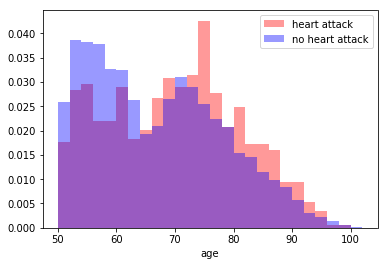

--------------------------------------------------
NULL count: 80
NULL perc: 0.5%


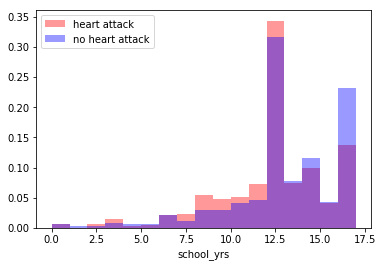

--------------------------------------------------
NULL count: 187
NULL perc: 1.1%


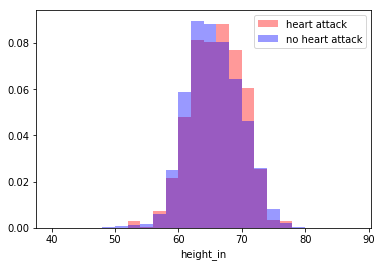

--------------------------------------------------
NULL count: 211
NULL perc: 1.3%


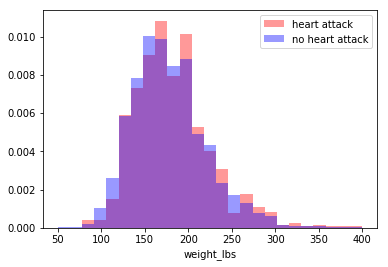

--------------------------------------------------
NULL count: 384
NULL perc: 2.4%


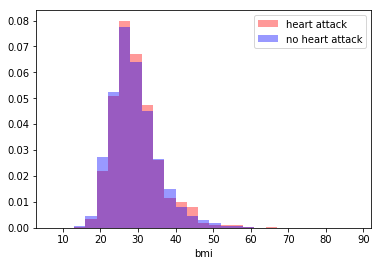

--------------------------------------------------
NULL count: 541
NULL perc: 3.3%


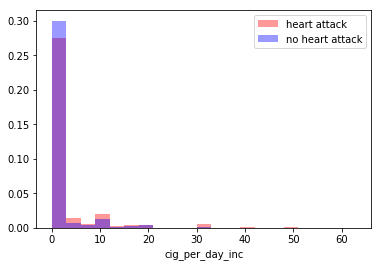

--------------------------------------------------
NULL count: 7320
NULL perc: 44.9%


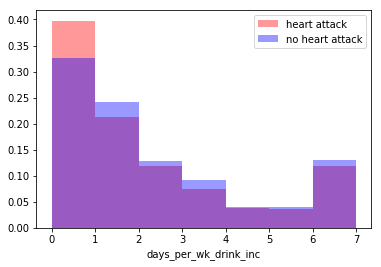

--------------------------------------------------
NULL count: 7320
NULL perc: 44.9%


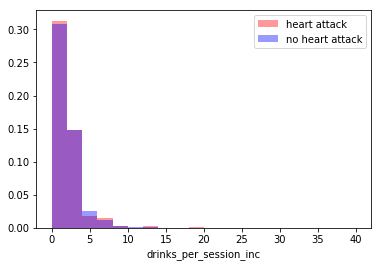

--------------------------------------------------
NULL count: 410
NULL perc: 2.5%


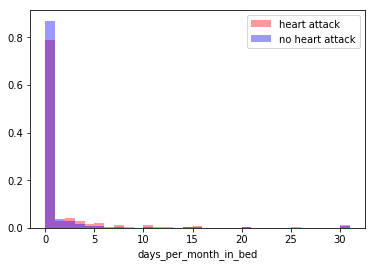

--------------------------------------------------


In [8]:
ha = xtrain[xtrain['heart_attack'] == 1]
nha = xtrain[xtrain['heart_attack'] == 0]
ha_color = 'red'
nha_color = 'blue'

# Create overlapping, normalized histograms to compare the distributions of the heart attack and 
# non-heart attack respondents in the specified continuous variable
def plot_continuous(d1, d2, col, d1_color, d2_color):
    dd1 = d1[d1[col].notnull()]
    dd2 = d2[d2[col].notnull()]
    print('NULL count:', str(d1[col].isnull().sum() + d2[col].isnull().sum()))
    print('NULL perc: ' + str(round((d1[col].isnull().sum() + d2[col].isnull().sum()) / (len(d1) + len(d2)) * 100, 1)) + '%')
    max_val = int(max(list(dd1[col]) + list(dd2[col]))) + 1
    min_val = int(min(list(dd1[col]) + list(dd2[col])))
    increments = int(round((max_val - min_val) / 25.0))
    if increments == 0:
        increments = 1
    sns.distplot(dd1[col].dropna().values, kde=False, bins=range(min_val, max_val, increments), norm_hist=True, color=d1_color, label='heart attack')
    sns.distplot(dd2[col].dropna().values, kde=False, bins=range(min_val, max_val, increments), norm_hist=True, color=d2_color, axlabel=col, label='no heart attack')
    plt.legend()

for iv in cont_ivs:
    plot_continuous(ha, nha, iv, ha_color, nha_color)
    plt.show()
    print('-' * 50)

Overall, we can detect (weak) correlations between all of the continuous variables and risk for a heart attack.  We know this because the normalized distributions for the heart attack victims are shifted relative to the distributions for the non-heart attack victims.

### Analyze Categorical Predictors

NULL count: 0
NULL perc: 0.0%


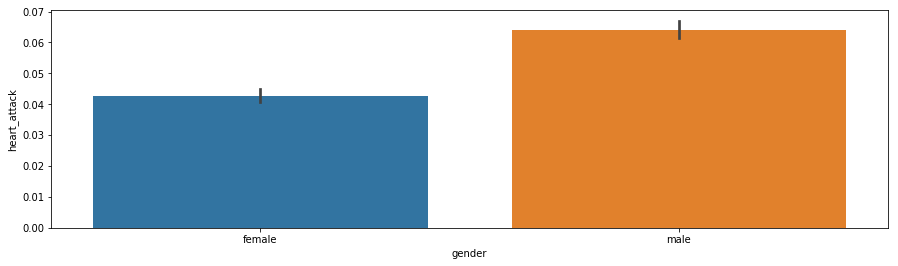

NULL count: 18
NULL perc: 0.1%


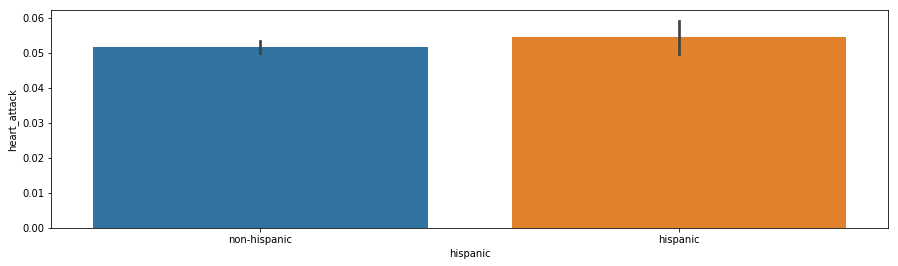

NULL count: 41
NULL perc: 0.3%


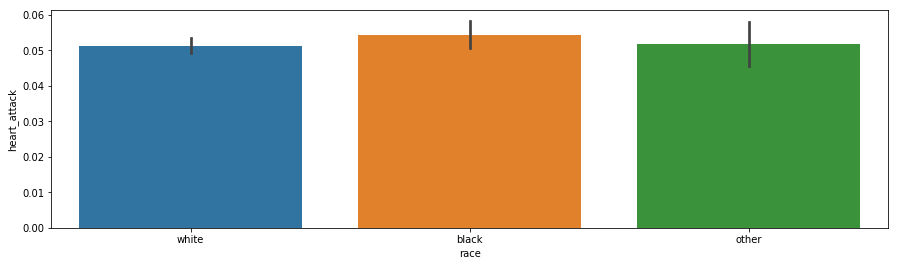

NULL count: 21
NULL perc: 0.1%


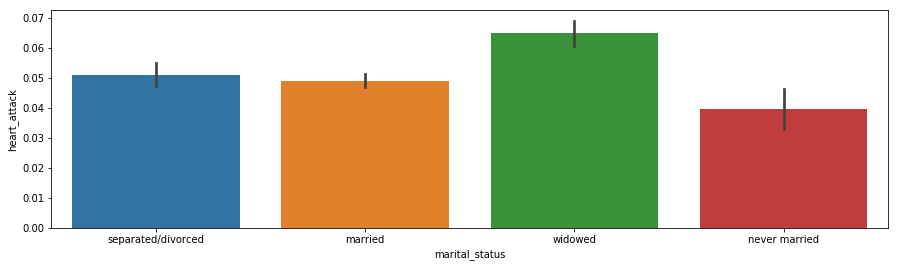

NULL count: 9
NULL perc: 0.1%


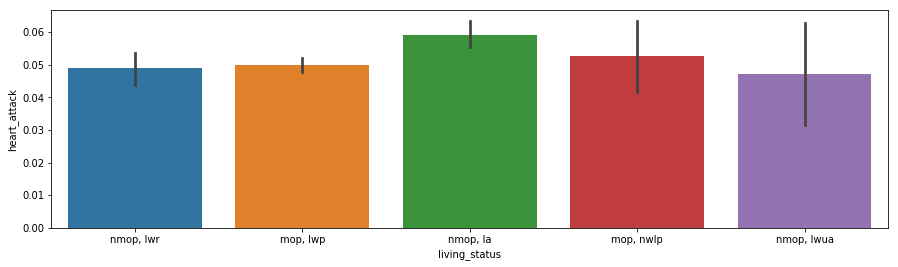

NULL count: 44
NULL perc: 0.3%


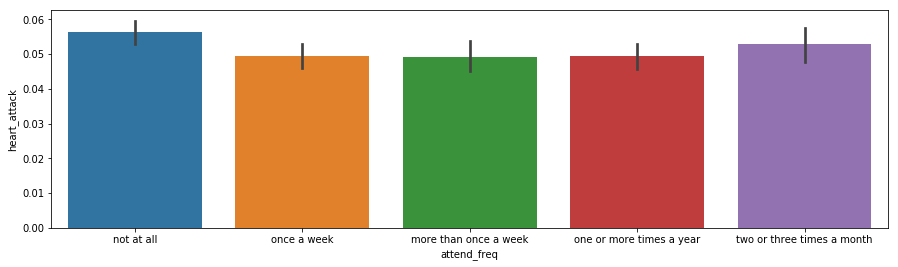

NULL count: 32
NULL perc: 0.2%


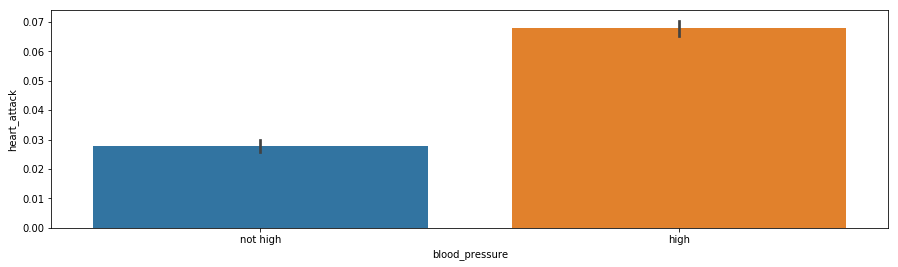

NULL count: 14
NULL perc: 0.1%


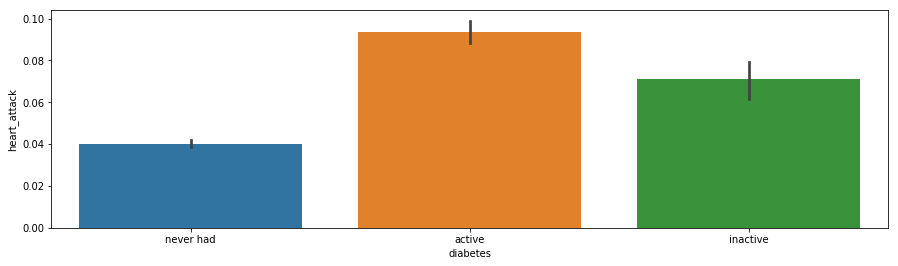

NULL count: 0
NULL perc: 0.0%


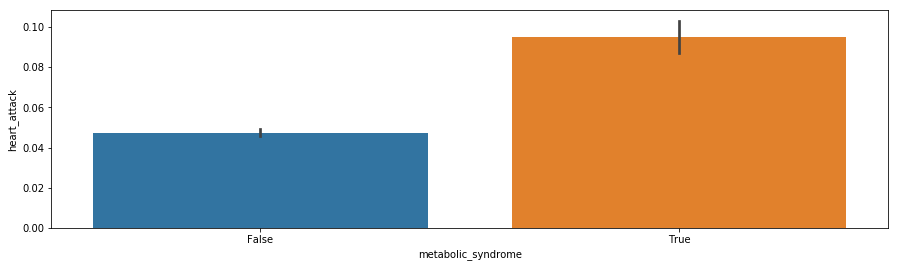

NULL count: 13
NULL perc: 0.1%


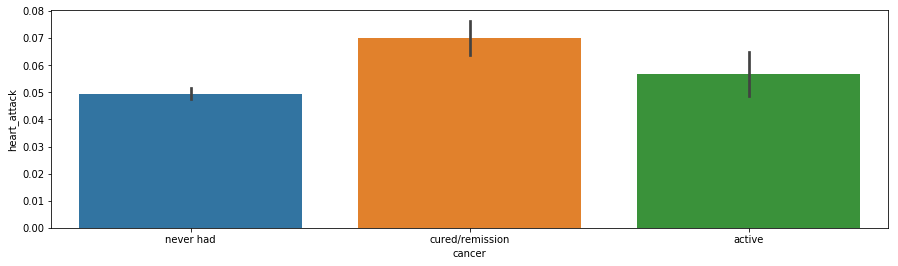

NULL count: 12
NULL perc: 0.1%


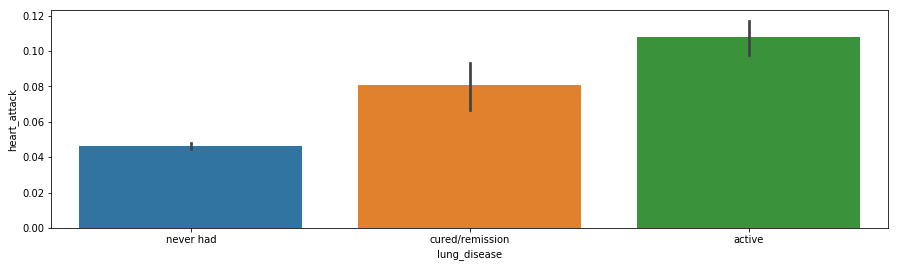

NULL count: 67
NULL perc: 0.4%


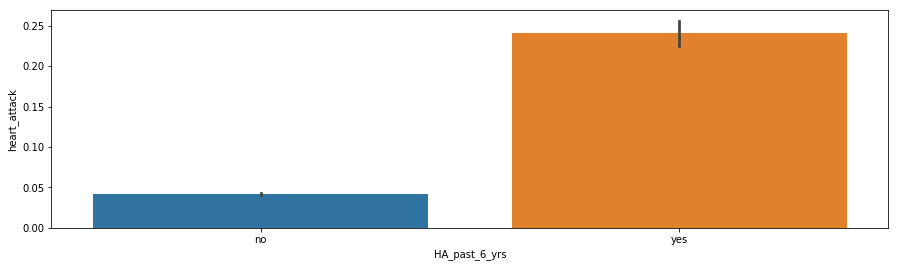

NULL count: 61
NULL perc: 0.4%


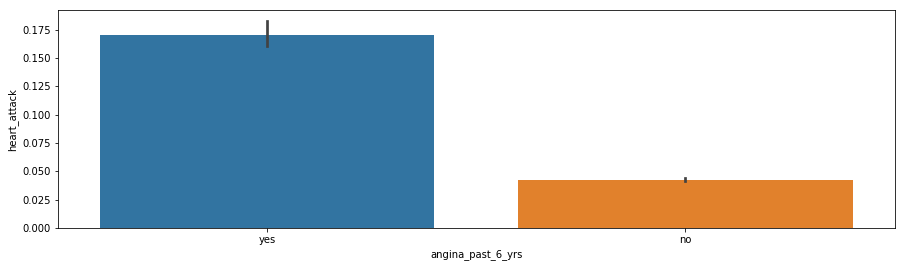

NULL count: 25
NULL perc: 0.2%


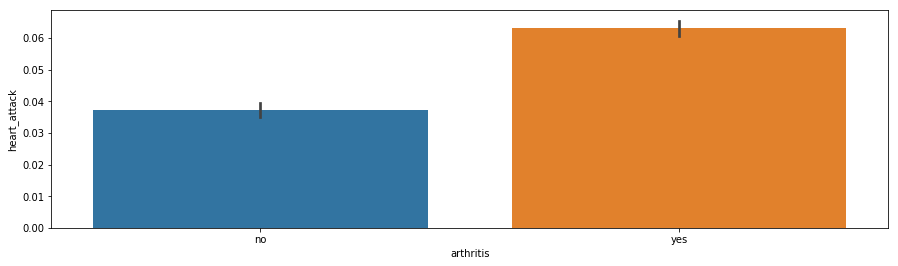

NULL count: 71
NULL perc: 0.4%


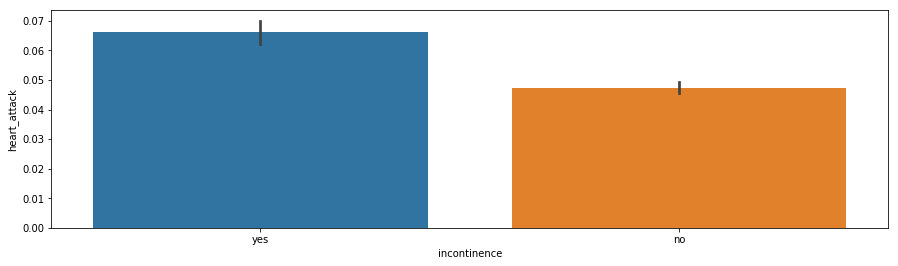

NULL count: 419
NULL perc: 2.6%


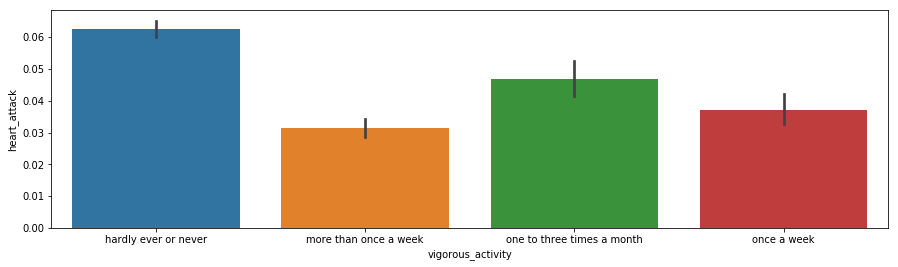

NULL count: 1130
NULL perc: 6.9%


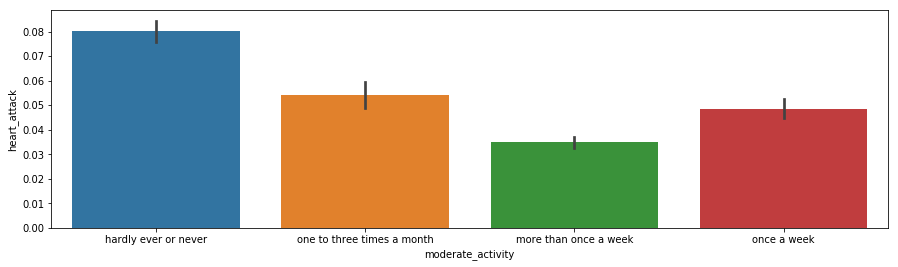

NULL count: 1352
NULL perc: 8.3%


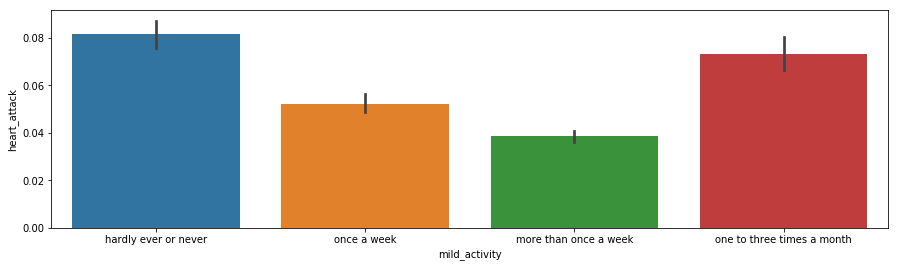

NULL count: 0
NULL perc: 0.0%


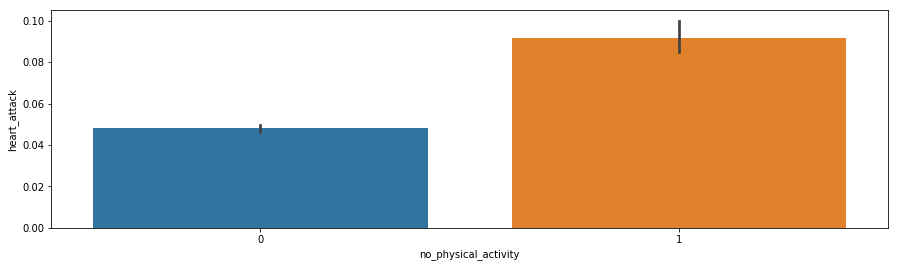

NULL count: 7048
NULL perc: 43.2%


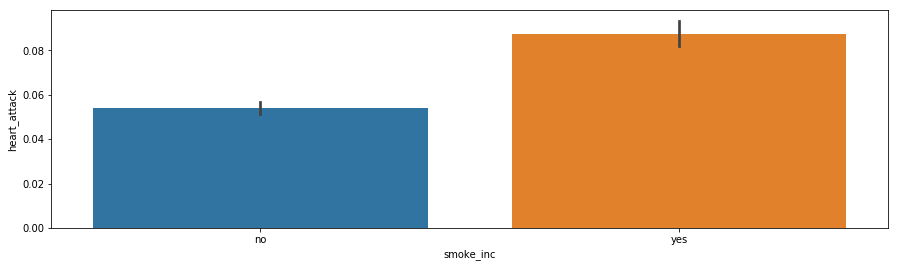

NULL count: 1025
NULL perc: 6.3%


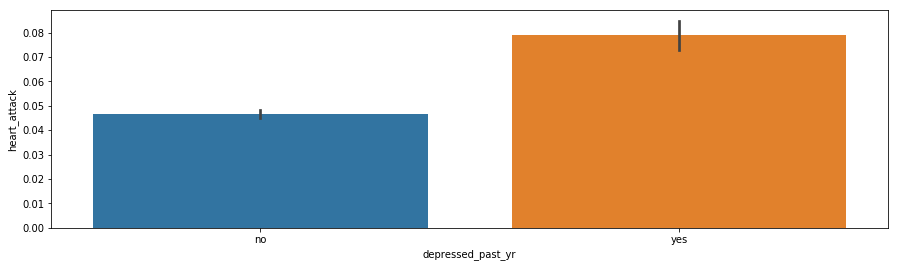

NULL count: 3342
NULL perc: 20.5%


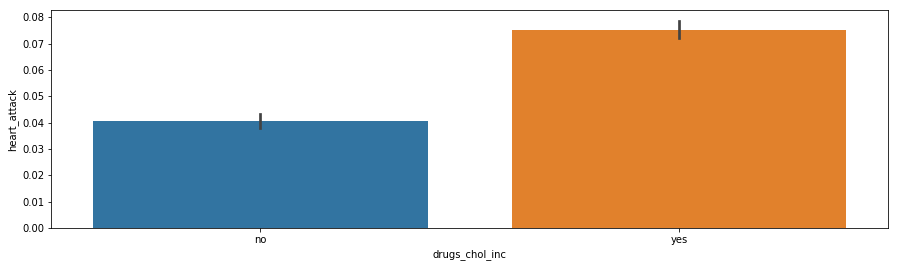

NULL count: 3303
NULL perc: 20.3%


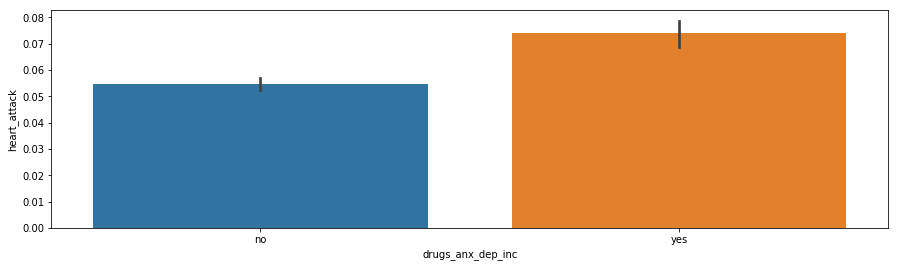

NULL count: 384
NULL perc: 2.4%


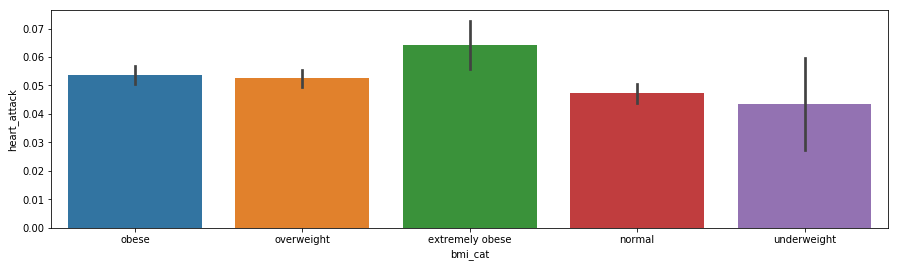

In [9]:
# Bar plots for categorical IVs
for iv in cat_ivs:
    plt.figure(figsize=(15, 4))
    print('NULL count:', xtrain[iv].isnull().sum())
    print('NULL perc: ' + str(round(xtrain[iv].isnull().sum() / len(xtrain) * 100, 1)) + '%')
    sns.barplot(x=iv, y="heart_attack", data=xtrain, ci=68)
    plt.show()
    print('=' * 100)

Almost all health-related predictors have some correlation, and in the directions we would expect. The only health-related measure that doesn't appear to have any association with heart attack is cancer incidence.  Among the demographics, gender and being a widow seemed to have a strong correlation with having a heart attack.

## Recode Data for Predictive Modeling

Convert all categorical variables into binary (0/1) variables, where 1 indicates the presence of the category and 0 indicates the absence of the category.  For instance, _hispanic_=1 indicates the person is Hispanic and _hispanic_=0 indicates the person is not Hispanic.

Recoding/imputation:
- Continuous:
    - age: no change
    - school_yrs:  impute median
    - height_in:  impute median by gender
    - weight_in:  impute median by gender
    - bmi:  impute median by gender
    - cig_per_day_inc:  drop
    - days_per_wk_drink_inc:  convert to binary indicator variable (drink), then impute using full logistic regression
    - drinks_per_session_inc:  drop
    - days_per_month_in_bed:  convert to binary indicator variable (bed_bound for > 1 day)

- Categorical:  impute all using mean
    - gender:  dummy for male
    - hispanic:  create dummy variable for hispanic
    - race:  create dummy variables for black and other
    - marital_status:  create dummy variables for widowed and never married
    - living_status:  dummy for never married or partnered, living alone (nmop, la)
    - attend_freq:  dummy for never attending
    - blood_pressure:  dummy for high
    - diabetes:  dummies for active and remission separate
    - metabolic_syndrome:  dummy
    - cancer:  dummy for current and remission separately
    - lung_disease:  dummy for active and remission separate
    - HA_past_6_yrs:  dummy
    - angina_past_6_yrs:  dummy 
    - arthritis:  dummy
    - incontinence:  dummy
    - vigorous_activity:  dummies for hardly ever and more than once a week, separate
    - moderate_activity:  dummies for hardly ever and more than once a week, separate
    - mild_activity:  dummies for hardly ever and more than once a week, separate
    - no_physical_activity:  dummy
    - smoke_inc:  dummy, then impute using logistic regression
    - depressed_past_yr:  dummy
    - drugs_chol_inc:  dummy, then impute using logistic regression
    - drugs_anx_dep_inc:  dummy, then impute using logistic regression
    - bmi_cat:  dummy for extremely obese

In [10]:
# Recode that continuous and categorical variables for predictive modeling (categorical to "dummy" 0/1 variables)
def recode_data(df):
    output = copy.deepcopy(df)
 
    output['male'] = (output['gender'] == 'male') * 1
    output['hispanic'] = output['hispanic'].map({'hispanic': 1, 'non-hispanic': 0})
    output['black'] = output['race'].map({'white': 0, 'black': 1, 'other': 0})
    output['other_race'] = output['race'].map({'white': 0, 'black': 0, 'other': 1})
    output['widowed'] = output['marital_status'].map({'married': 0, 'widowed': 1, 'separated/divorced': 0, 'never married': 0})
    output['never_married'] = output['marital_status'].map({'married': 0, 'widowed': 0, 'separated/divorced': 0, 'never married': 1})
    output['live_alone'] = output['living_status'].map({'mop, lwp': 0, 'nmop, la': 1, 'nmop, lwr': 0, 'mop, nwlp': 0, 'nmop, lwua': 0})
    output['never_attend'] = output['attend_freq'].map({'not at all': 1, 'once a week': 0, 'one or more times a year': 0, 'more than once a week': 0, 'two or three times a month': 0})
    output['high_blood_pressure'] = output['blood_pressure'].map({'high': 1, 'not high': 0})
    output['diabetes_active'] = output['diabetes'].map({'never had': 0, 'active': 1, 'inactive': 0})
    output['diabetes_remission'] = output['diabetes'].map({'never had': 0, 'active': 0, 'inactive': 1})
    output['one_of_3_null'] = (output['blood_pressure'].isnull()) | (output['bmi'].isnull()) | (output['diabetes'].isnull())
    metabolic_syndrome = []
    for r in output.to_dict('records'):
        if r['one_of_3_null']:
            metabolic_syndrome.append(None)
        elif r['blood_pressure'] == 'high' and r['bmi'] >= 30 and r['diabetes'] == 'active':
            metabolic_syndrome.append(1)
        else:
            metabolic_syndrome.append(0)
    output['metabolic_syndrome'] = metabolic_syndrome
    output['cancer_active'] = output['cancer'].map({'never had': 0, 'cured/remission': 0, 'active': 1})
    output['cancer_remission'] = output['cancer'].map({'never had': 0, 'cured/remission': 1, 'active': 0})
    output['lung_disease_active'] = output['lung_disease'].map({'never had': 0, 'active': 1, 'cured/remission': 0})
    output['lung_disease_remission'] = output['lung_disease'].map({'never had': 0, 'active': 0, 'cured/remission': 1})
    output['HA_past_6_yrs'] = output['HA_past_6_yrs'].map({'no': 0, 'yes': 1})
    output['angina_past_6_yrs'] = output['angina_past_6_yrs'].map({'no': 0, 'yes': 1})
    output['arthritis'] = output['arthritis'].map({'yes': 1, 'no': 0})
    output['incontinence'] = output['incontinence'].map({'yes': 1, 'no': 0})
    output['vig_act_never'] = output['vigorous_activity'].map({'hardly ever or never': 1, 'more than once a week': 0, 'once a week': 0, 'one to three times a month': 0})
    output['vig_act_often'] = output['vigorous_activity'].map({'hardly ever or never': 0, 'more than once a week': 1, 'once a week': 0, 'one to three times a month': 0})
    output['mod_act_never'] = output['moderate_activity'].map({'hardly ever or never': 1, 'more than once a week': 0, 'once a week': 0, 'one to three times a month': 0})
    output['mod_act_often'] = output['moderate_activity'].map({'hardly ever or never': 0, 'more than once a week': 1, 'once a week': 0, 'one to three times a month': 0})
    output['mild_act_never'] = output['mild_activity'].map({'hardly ever or never': 1, 'more than once a week': 0, 'once a week': 0, 'one to three times a month': 0})
    output['mild_act_often'] = output['mild_activity'].map({'hardly ever or never': 0, 'more than once a week': 1, 'once a week': 0, 'one to three times a month': 0})
    output['missing_activity_data'] = (xtrain['vigorous_activity'].isnull()) | (xtrain['moderate_activity'].isnull()) | (xtrain['mild_activity'].isnull())
    no_physical_activity = []
    for r in output.to_dict('records'):
        if r['missing_activity_data']:
            no_physical_activity.append(None)
        elif r['vig_act_never'] == 1 and r['mod_act_never'] == 1 and r['mild_act_never'] == 1:
            no_physical_activity.append(1)
        else:
            no_physical_activity.append(0)
    output['no_physical_activity'] = no_physical_activity
    output['smoke'] = output['smoke_inc'].map({'yes': 1, 'no': 0})
    output['depressed'] = output['depressed_past_yr'].map({'yes': 1, 'no': 0})
    output['drugs_chol'] = output['drugs_chol_inc'].map({'yes': 1, 'no': 0})
    output['drugs_anx_dep'] = output['drugs_anx_dep_inc'].map({'yes': 1, 'no': 0})
    output['extremely_obese'] = output['bmi_cat'].map({'overweight': 0, 'obese': 0, 'normal': 0, 'extremely obese': 1, 'underweight': 0})
    output['drink_alcohol'] = output['days_per_wk_drink_inc'].map({0.0: 0, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1, 5.0: 1, 6.0: 1, 7.0: 1})
    day_map = dict([[v, 1] if v > 1 else [v, 0] for v in list(output[output['days_per_month_in_bed'].notnull()]['days_per_month_in_bed'].unique())])
    output['mt_1_day_in_bed'] = output['days_per_month_in_bed'].map(day_map)
    
    return output

xtrain2 = recode_data(xtrain)

In [11]:
# Get the updated categorical and continuous variables that will be used in the deep learning model
cont_ivs2 = ['age', 'school_yrs', 'height_in', 'weight_lbs', 'bmi']
cat_ivs2 = [ 
    'male', 'hispanic', 'black', 'other_race', 'widowed', 'never_married', 'live_alone', 'never_attend', 
    'high_blood_pressure', 'diabetes_active', 'diabetes_remission', 'metabolic_syndrome', 'cancer_active', 
    'cancer_remission', 'lung_disease_active', 'lung_disease_remission', 'HA_past_6_yrs', 'angina_past_6_yrs', 
    'arthritis', 'incontinence', 'vig_act_never', 'vig_act_often', 'mod_act_never', 'mod_act_often', 
    'mild_act_never', 'mild_act_often', 'no_physical_activity', 'smoke', 'depressed', 'drugs_chol', 
    'drugs_anx_dep', 'extremely_obese', 'drink_alcohol', 'mt_1_day_in_bed'
]

log_reg_impute_cat_ivs = ['no_physical_activity', 'smoke', 'drugs_chol', 'drugs_anx_dep', 'drink_alcohol']
mean_impute_cols = [col for col in cat_ivs2 if col not in log_reg_impute_cat_ivs]

### Impute (Replace) Missing Values

If less than 10% of values are missing, impute using the median for continuous variables (or median stratified by gender for height, weight, and BMI variables) and mean for categorical (binary) variables (based on recommendations from https://www.theanalysisfactor.com/multiple-imputation-of-categorical-variables/).

If greater than 10% of values are missing (only the case for 5 categorical variables), use logistic regression models to predict the values.  Only do this after the variables with less than 10% missing values have been imputed (use all of these variables as the predictors in the logistic regression model).

Save the means, medians, and logistic regression models used for imputation on the training set so these same statistics/models can be used to impute the test set.

In [12]:
# Get the imputation statistics (mean/median) for variables with less than 10% NULL values
def get_lt_10_perc_impute_stats(df, median_cols, mean_cols):
    impute_stats = {}
    for col in median_cols:
        impute_stats[col] = df[col].median()
    for col in mean_cols:
        impute_stats[col] = df[col].mean()
    return impute_stats
        
impute_stats = get_lt_10_perc_impute_stats(xtrain2, cont_ivs2, mean_impute_cols)
print(impute_stats)

{'age': 66.0, 'school_yrs': 12.0, 'height_in': 65.25, 'weight_lbs': 175.0, 'bmi': 28.172809405050934, 'male': 0.4265644171779141, 'hispanic': 0.12885394914629653, 'black': 0.194107878713328, 'other_race': 0.07946368165323821, 'widowed': 0.18784937649732786, 'never_married': 0.054241661035690156, 'live_alone': 0.2187711006076975, 'never_attend': 0.26531742125984253, 'high_blood_pressure': 0.601057290386034, 'diabetes_active': 0.19108436694093087, 'diabetes_remission': 0.04500798231609972, 'metabolic_syndrome': 0.09528907922912205, 'cancer_active': 0.045312212193774175, 'cancer_remission': 0.09719408116903051, 'lung_disease_active': 0.07342829076620826, 'lung_disease_remission': 0.030329076620825148, 'HA_past_6_yrs': 0.049343929033450376, 'angina_past_6_yrs': 0.07112506927766488, 'arthritis': 0.5639324116743472, 'incontinence': 0.2384620124468544, 'vig_act_never': 0.584597947232542, 'vig_act_often': 0.2212077325105472, 'mod_act_never': 0.26407382992748846, 'mod_act_often': 0.422412656558

In [13]:
# Create a new dataset with all of the imputed values filled in
def impute_lt_10_perc_predictors(df, impute_stats):
    output = copy.deepcopy(df)
    for col, stat in impute_stats.items():
        output[col] = output[col].fillna(stat)
    return output

xtrain3 = impute_lt_10_perc_predictors(xtrain2, impute_stats)
for iv in cont_ivs2 + cat_ivs2:
    if xtrain3[iv].isnull().sum() > 0:
        print(iv)

no_physical_activity
smoke
drugs_chol
drugs_anx_dep
drink_alcohol


In [14]:
# Get the imputation models (logistic regression) for the variables with >= 10% NULL values
def get_gt_10_per_impute_models(df, dvs, ivs):
    d2 = copy.deepcopy(df)
    models = {}
    for iv in ivs:
        models[iv + '_mean'] = d2[iv].mean()
        models[iv + '_std'] = d2[iv].std()
        d2[iv] = (d2[iv] - d2[iv].mean()) / d2[iv].std()
    for dv in dvs:
        d2_nonull = d2[d2[dv].notnull()]
        print("Variable distribution for non-NULL values")
        print(d2_nonull[dv].value_counts(dropna=False) / len(d2_nonull))
        d2_isnull = d2[d2[dv].isnull()]        
        if dv == 'no_physical_activity':
            C = 0.0006
        else:
            C = 1.0
        logit2 = LogisticRegression(penalty='l1', C=C).fit(d2_nonull[ivs], d2_nonull[dv])
        pred2 = logit2.predict(d2_isnull[ivs])
        print("Variable distribution for IMPUTED values")
        print(pd.Series(pred2).value_counts(dropna=False) / len(pred2))
        models[dv] = logit2
        print('=' * 100)
    return models

impute_models = get_gt_10_per_impute_models(xtrain3, log_reg_impute_cat_ivs, cont_ivs2 + mean_impute_cols)

Variable distribution for non-NULL values
0.0    0.897751
1.0    0.102249
Name: no_physical_activity, dtype: float64
Variable distribution for IMPUTED values
0.0    0.945174
1.0    0.054826
dtype: float64
Variable distribution for non-NULL values
0.0    0.737138
1.0    0.262862
Name: smoke, dtype: float64
Variable distribution for IMPUTED values
0.0    0.928774
1.0    0.071226
dtype: float64
Variable distribution for non-NULL values
1.0    0.531872
0.0    0.468128
Name: drugs_chol, dtype: float64
Variable distribution for IMPUTED values
0.0    0.880012
1.0    0.119988
dtype: float64
Variable distribution for non-NULL values
0.0    0.775256
1.0    0.224744
Name: drugs_anx_dep, dtype: float64
Variable distribution for IMPUTED values
0.0    0.953981
1.0    0.046019
dtype: float64
Variable distribution for non-NULL values
1.0    0.670267
0.0    0.329733
Name: drink_alcohol, dtype: float64
Variable distribution for IMPUTED values
1.0    0.76735
0.0    0.23265
dtype: float64


Performance of the imputation models is mediocre at best, but I don't have time right now to work on improving.

In [15]:
# Impute data for variables with >= 10% of observations missing (NULL)
def impute_gt_10_perc_predictors(df, ivs, impute_ivs, imputation_models):
    output = copy.deepcopy(df)
    output2 = copy.deepcopy(df)
    for iv in ivs:
        output2[iv] = (output2[iv] - imputation_models[iv + '_mean']) / imputation_models[iv + '_std']
    for iv in impute_ivs:
        # Relies on the predictor and target data frames to have the same order
        print(output[iv].value_counts(dropna=False))
        print('*' * 25)
        output_not_imputed = output[output[iv].notnull()]
        output_imputed = output[output[iv].isnull()]
        output_imputed_predictors = output2[output2[iv].isnull()]
        output_imputed[iv] = imputation_models[iv].predict(output_imputed_predictors[ivs])
        output = output_not_imputed.append(output_imputed)
        print(output[iv].value_counts(dropna=False))
        print('-' * 50)
    return output
            
xtrain4 = impute_gt_10_perc_predictors(xtrain3, cont_ivs2 + mean_impute_cols, log_reg_impute_cat_ivs, impute_models)

 0.0    12652
NaN      2207
 1.0     1441
Name: no_physical_activity, dtype: int64
*************************
0.0    14738
1.0     1562
Name: no_physical_activity, dtype: int64
--------------------------------------------------
NaN     7048
 0.0    6820
 1.0    2432
Name: smoke, dtype: int64
*************************
0.0    13366
1.0     2934
Name: smoke, dtype: int64
--------------------------------------------------
 1.0    6892
 0.0    6066
NaN     3342
Name: drugs_chol, dtype: int64
*************************
0.0    9007
1.0    7293
Name: drugs_chol, dtype: int64
--------------------------------------------------
 0.0    10076
NaN      3303
 1.0     2921
Name: drugs_anx_dep, dtype: int64
*************************
0.0    13227
1.0     3073
Name: drugs_anx_dep, dtype: int64
--------------------------------------------------
NaN     7320
 1.0    6019
 0.0    2961
Name: drink_alcohol, dtype: int64
*************************
1.0    11636
0.0     4664
Name: drink_alcohol, dtype: int64
-----

In [16]:
full_ivs = cont_ivs2 + cat_ivs2
xtrain5 = xtrain4[full_ivs + ['heart_attack']]
xtrain5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16300 entries, 9059 to 1816
Data columns (total 40 columns):
age                       16300 non-null int64
school_yrs                16300 non-null float64
height_in                 16300 non-null float64
weight_lbs                16300 non-null float64
bmi                       16300 non-null float64
male                      16300 non-null int64
hispanic                  16300 non-null float64
black                     16300 non-null float64
other_race                16300 non-null float64
widowed                   16300 non-null float64
never_married             16300 non-null float64
live_alone                16300 non-null float64
never_attend              16300 non-null float64
high_blood_pressure       16300 non-null float64
diabetes_active           16300 non-null float64
diabetes_remission        16300 non-null float64
metabolic_syndrome        16300 non-null float64
cancer_active             16300 non-null float64
cancer_remi

## Review Results of Data Recoding and Imputation

In [17]:
xtrain5['heart_attack'].value_counts(dropna=False)

0    15455
1      845
Name: heart_attack, dtype: int64

NULL count: 0
NULL perc: 0.0%


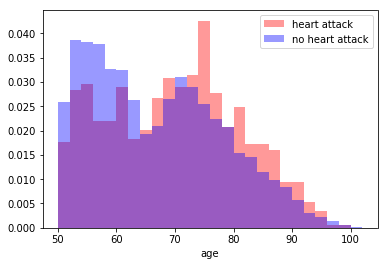

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


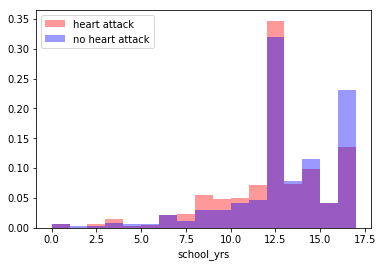

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


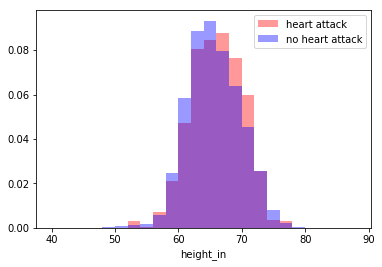

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


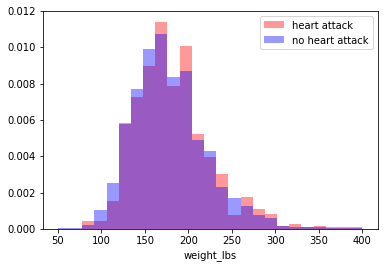

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


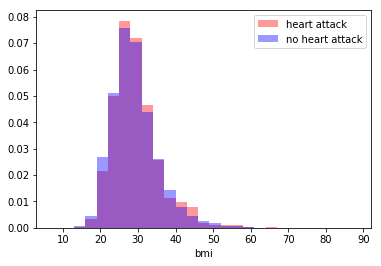

--------------------------------------------------


In [18]:
ha2 = xtrain5[xtrain5['heart_attack'] == 1]
nha2 = xtrain5[xtrain5['heart_attack'] == 0]

for iv in cont_ivs2:
    plot_continuous(ha2, nha2, iv, ha_color, nha_color)
    plt.show()
    print('-' * 50)

NULL count: 0
NULL perc: 0.0%


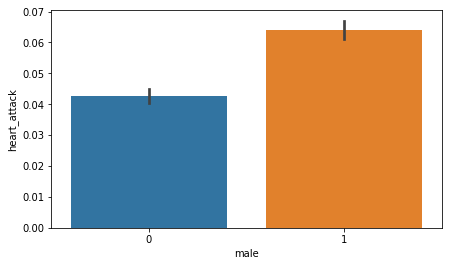

NULL count: 0
NULL perc: 0.0%


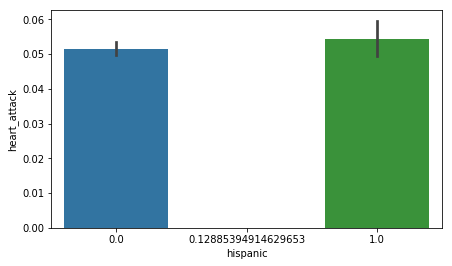

NULL count: 0
NULL perc: 0.0%


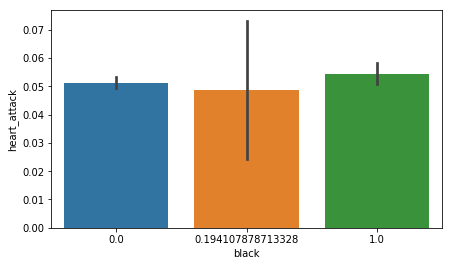

NULL count: 0
NULL perc: 0.0%


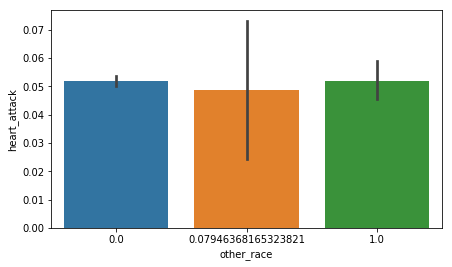

NULL count: 0
NULL perc: 0.0%


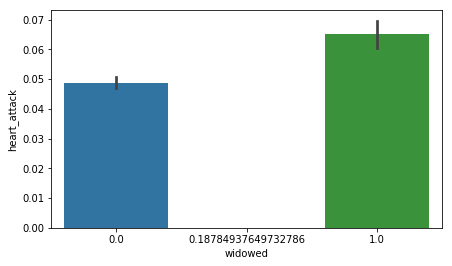

NULL count: 0
NULL perc: 0.0%


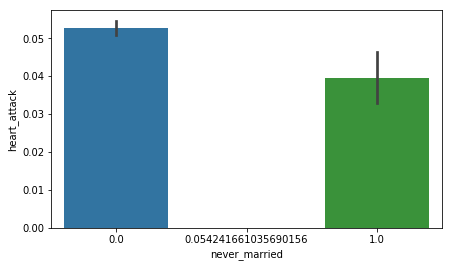

NULL count: 0
NULL perc: 0.0%


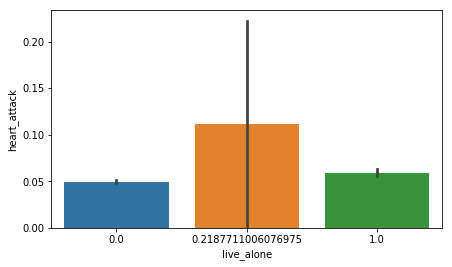

NULL count: 0
NULL perc: 0.0%


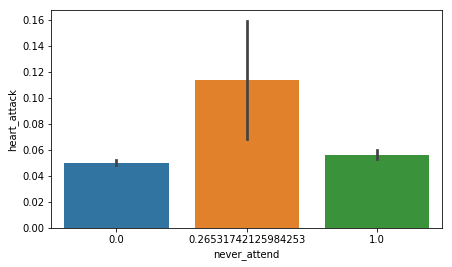

NULL count: 0
NULL perc: 0.0%


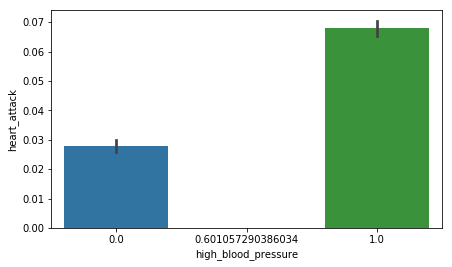

NULL count: 0
NULL perc: 0.0%


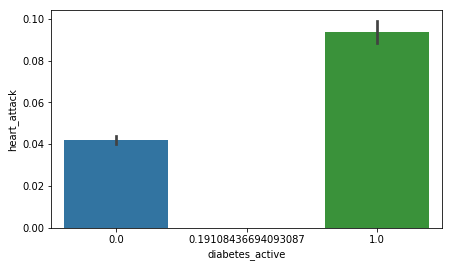

NULL count: 0
NULL perc: 0.0%


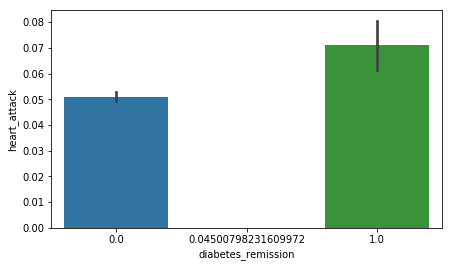

NULL count: 0
NULL perc: 0.0%


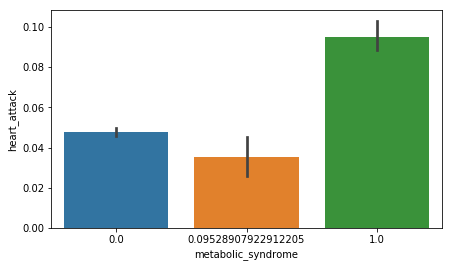

NULL count: 0
NULL perc: 0.0%


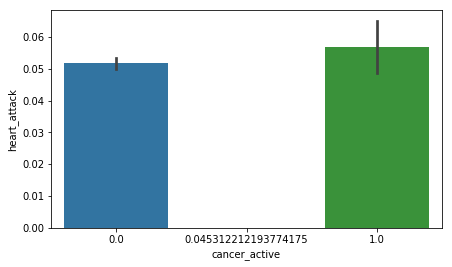

NULL count: 0
NULL perc: 0.0%


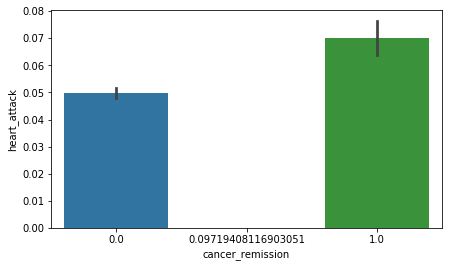

NULL count: 0
NULL perc: 0.0%


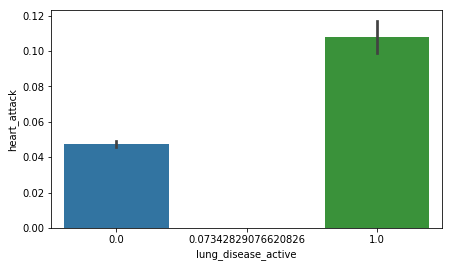

NULL count: 0
NULL perc: 0.0%


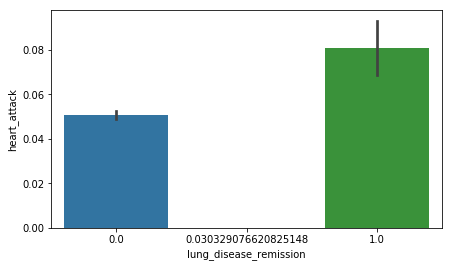

NULL count: 0
NULL perc: 0.0%


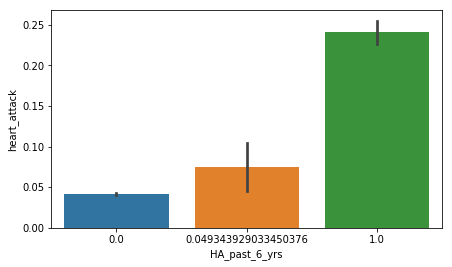

NULL count: 0
NULL perc: 0.0%


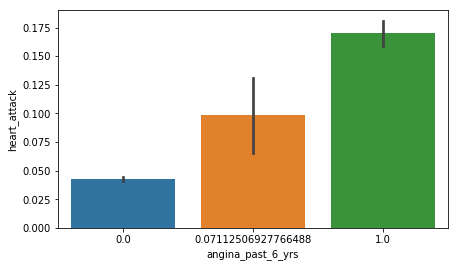

NULL count: 0
NULL perc: 0.0%


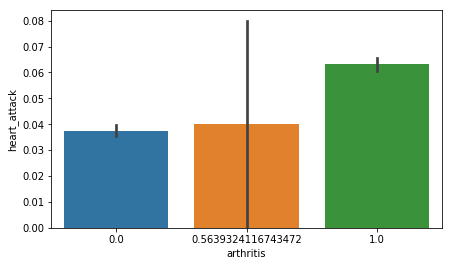

NULL count: 0
NULL perc: 0.0%


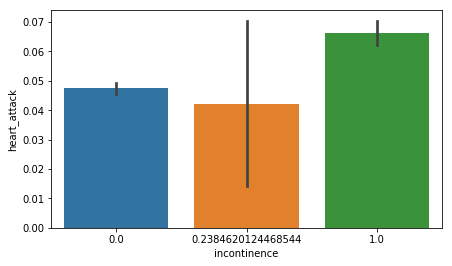

NULL count: 0
NULL perc: 0.0%


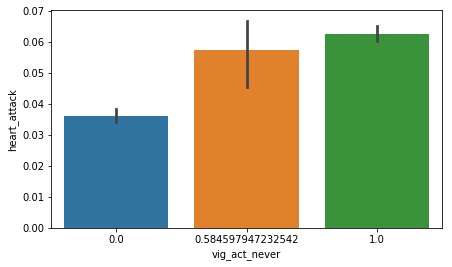

NULL count: 0
NULL perc: 0.0%


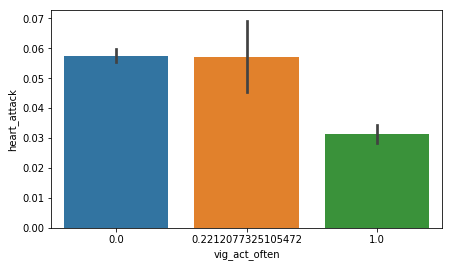

NULL count: 0
NULL perc: 0.0%


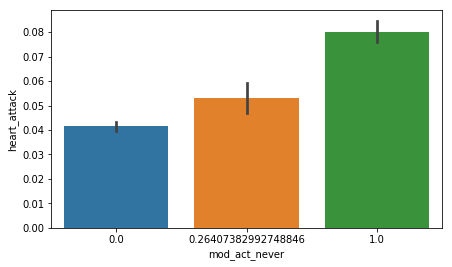

NULL count: 0
NULL perc: 0.0%


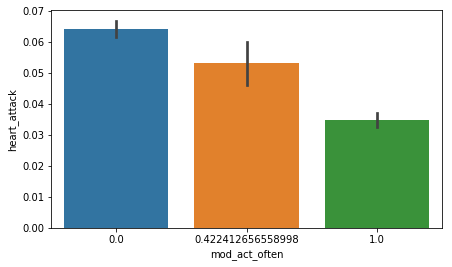

NULL count: 0
NULL perc: 0.0%


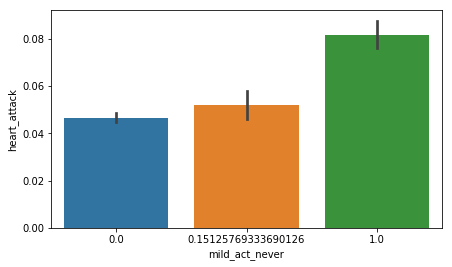

NULL count: 0
NULL perc: 0.0%


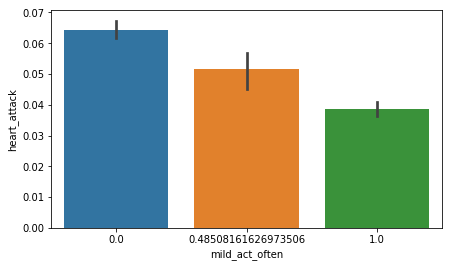

NULL count: 0
NULL perc: 0.0%


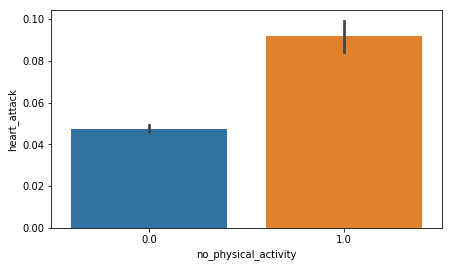

NULL count: 0
NULL perc: 0.0%


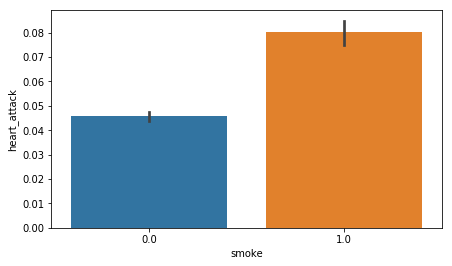

NULL count: 0
NULL perc: 0.0%


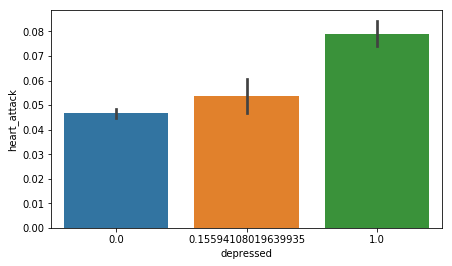

NULL count: 0
NULL perc: 0.0%


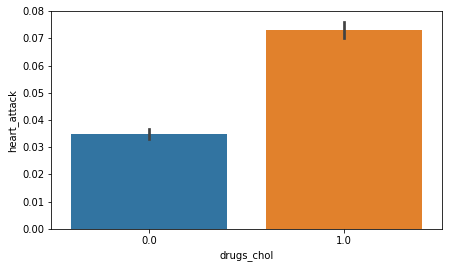

NULL count: 0
NULL perc: 0.0%


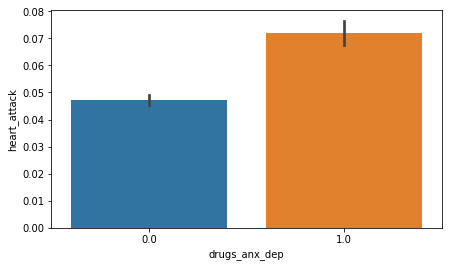

NULL count: 0
NULL perc: 0.0%


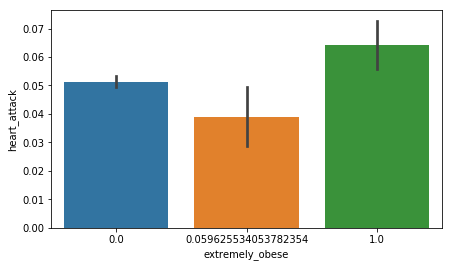

NULL count: 0
NULL perc: 0.0%


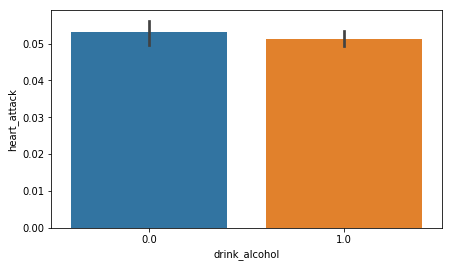

NULL count: 0
NULL perc: 0.0%


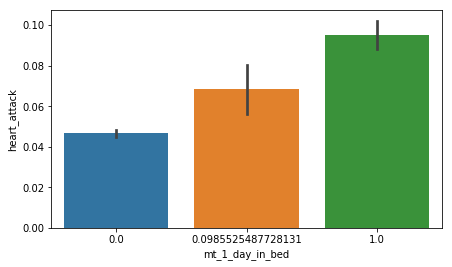

In [19]:
# Bar plots for categorical IVs
for iv in cat_ivs2:
    plt.figure(figsize=(7, 4))
    print('NULL count:', xtrain5[iv].isnull().sum())
    print('NULL perc: ' + str(round(xtrain5[iv].isnull().sum() / len(xtrain5) * 100, 1)) + '%')
    sns.barplot(x=iv, y="heart_attack", data=xtrain5, ci=68)
    plt.show()
    print('=' * 100)

Overall, everything looks reasonable.

## Rescale the Data

Rescale predictors by subtracting the mean and dividing by the standard deviation.  Save the mean and standard deviation so the process can then be applied to the test data as well.

In [20]:
# Get parameters to rescale data
def get_rescale_parameters(df, ivs):
    params = {}
    for iv in ivs:
        params[iv + '_mean'] = df[iv].mean()
        params[iv + '_std'] = df[iv].std()
    return params

# Rescale data using supplied means and standard deviations
def rescale_data(df, ivs, rescale_params):
    output = copy.deepcopy(df)
    for iv in ivs:
        output[iv] = (output[iv] - rescale_params[iv + '_mean']) / rescale_params[iv + '_std']
    return output

rescale_params = get_rescale_parameters(xtrain5, full_ivs)
xtrain6 = rescale_data(xtrain5, full_ivs, rescale_params)
print(xtrain6.info())
xtrain6.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16300 entries, 9059 to 1816
Data columns (total 40 columns):
age                       16300 non-null float64
school_yrs                16300 non-null float64
height_in                 16300 non-null float64
weight_lbs                16300 non-null float64
bmi                       16300 non-null float64
male                      16300 non-null float64
hispanic                  16300 non-null float64
black                     16300 non-null float64
other_race                16300 non-null float64
widowed                   16300 non-null float64
never_married             16300 non-null float64
live_alone                16300 non-null float64
never_attend              16300 non-null float64
high_blood_pressure       16300 non-null float64
diabetes_active           16300 non-null float64
diabetes_remission        16300 non-null float64
metabolic_syndrome        16300 non-null float64
cancer_active             16300 non-null float64
cancer_

,age,school_yrs,height_in,weight_lbs,bmi,male,hispanic,black,other_race,widowed,...,mild_act_often,no_physical_activity,smoke,depressed,drugs_chol,drugs_anx_dep,extremely_obese,drink_alcohol,mt_1_day_in_bed,heart_attack
9059,0.028361,-0.182221,-0.175639,0.511331,0.696950,-0.862455,-0.384796,2.040095,-0.294169,-0.481231,...,-1.013508,-0.325543,-0.468507,-0.444001,-0.899808,-0.481989,-0.254817,0.633088,-0.334875,0
9153,-0.415377,-0.182221,-0.903507,0.347762,1.021181,-0.862455,2.601496,-0.491379,-0.294169,-0.481231,...,1.075848,-0.325543,-0.468507,-0.444001,-0.899808,2.074608,-0.254817,-1.579462,-0.334875,0
18138,-1.125357,-0.493042,-0.842851,-0.470082,-0.037980,-0.862455,2.601496,-0.491379,3.407765,-0.481231,...,-1.013508,-0.325543,2.134309,2.403234,1.111280,2.074608,-0.254817,0.633088,-0.334875,1
12655,-0.859115,1.061063,1.098129,0.090726,-0.478922,1.159409,-0.384796,-0.491379,-0.294169,-0.481231,...,1.075848,-0.325543,-0.468507,-0.444001,-0.899808,-0.481989,-0.254817,0.633088,-0.334875,0
16623,-1.125357,0.750242,0.855506,-0.540183,-0.989622,1.159409,-0.384796,2.040095,-0.294169,-0.481231,...,1.075848,-0.325543,2.134309,-0.444001,1.111280,-0.481989,-0.254817,0.633088,-0.334875,0


## Process the Test Set

Using the functions above, recode the test set, impute the values, and rescale.  Use the means, medians, and logistic regression models from the training set to impute the test set values.  Also use the means and standard deviations from the training set to rescale the test set values before using for prediction.

In [21]:
# Process the test data
print(xtest.shape)
xtest2 = recode_data(xtest)
xtest3 = impute_lt_10_perc_predictors(xtest2, impute_stats)
xtest4 = impute_gt_10_perc_predictors(xtest3, cont_ivs2 + mean_impute_cols, log_reg_impute_cat_ivs, impute_models)
xtest5 = xtest4[full_ivs + ['heart_attack']]
xtest6 = rescale_data(xtest5, full_ivs, rescale_params)
print(xtest6.info())
xtest6.head()

(4076, 47)
NaN    4076
Name: no_physical_activity, dtype: int64
*************************
0.0    3499
1.0     577
Name: no_physical_activity, dtype: int64
--------------------------------------------------
NaN     1833
 0.0    1621
 1.0     622
Name: smoke, dtype: int64
*************************
0.0    3328
1.0     748
Name: smoke, dtype: int64
--------------------------------------------------
 1.0    1664
 0.0    1576
NaN      836
Name: drugs_chol, dtype: int64
*************************
0.0    2326
1.0    1750
Name: drugs_chol, dtype: int64
--------------------------------------------------
 0.0    2539
NaN      824
 1.0     713
Name: drugs_anx_dep, dtype: int64
*************************
0.0    3323
1.0     753
Name: drugs_anx_dep, dtype: int64
--------------------------------------------------
NaN     1848
 1.0    1455
 0.0     773
Name: drink_alcohol, dtype: int64
*************************
1.0    2888
0.0    1188
Name: drink_alcohol, dtype: int64
-----------------------------------

,age,school_yrs,height_in,weight_lbs,bmi,male,hispanic,black,other_race,widowed,...,mild_act_often,no_physical_activity,smoke,depressed,drugs_chol,drugs_anx_dep,extremely_obese,drink_alcohol,mt_1_day_in_bed,heart_attack
2145,0.294604,-0.182221,-0.842851,0.043992,0.599268,-0.862455,-0.384796,-0.491379,-0.294169,-0.481231,...,1.075848,-0.325543,-0.468507,-4.440008e-01,1.111280,-0.481989,-0.254817,0.633088,-0.334875,0
13355,-0.859115,-0.182221,2.068619,0.043992,-0.954602,1.159409,-0.384796,-0.491379,-0.294169,-0.481231,...,1.075848,-0.325543,-0.468507,-1.335550e-14,1.111280,-0.481989,-0.254817,0.633088,-0.334875,0
15483,-1.036610,0.750242,0.370261,-0.376614,-0.596350,-0.862455,-0.384796,-0.491379,-0.294169,-0.481231,...,1.075848,-0.325543,-0.468507,2.403234e+00,-0.899808,2.074608,-0.254817,0.633088,-0.334875,0
12492,-0.415377,1.061063,0.673539,1.095506,0.763737,1.159409,-0.384796,-0.491379,-0.294169,-0.481231,...,-1.013508,-0.325543,2.134309,-4.440008e-01,-0.899808,-0.481989,-0.254817,0.633088,-0.334875,0
12457,-0.504124,0.128600,0.370261,-0.773853,-1.018016,1.159409,-0.384796,-0.491379,-0.294169,-0.481231,...,1.075848,-0.325543,2.134309,-4.440008e-01,1.111280,-0.481989,-0.254817,0.633088,-0.334875,0


### Visualize Results of Recoding and Imputing Test Set

NULL count: 0
NULL perc: 0.0%


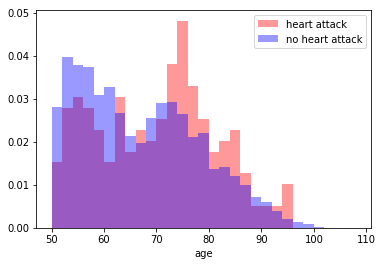

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


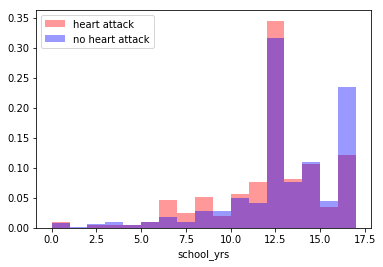

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


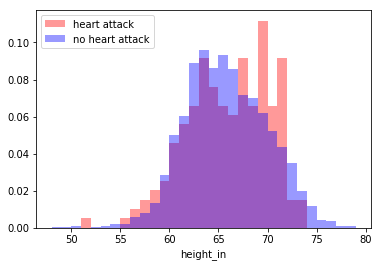

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


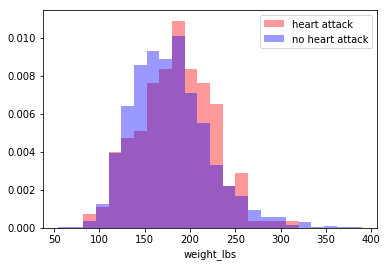

--------------------------------------------------
NULL count: 0
NULL perc: 0.0%


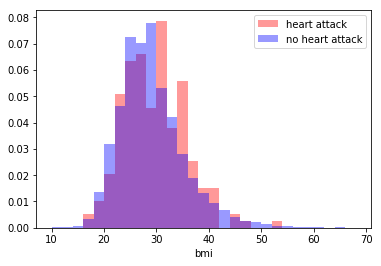

--------------------------------------------------


In [22]:
ha3 = xtest5[xtest5['heart_attack'] == 1]
nha3 = xtest5[xtest5['heart_attack'] == 0]

for iv in cont_ivs2:
    plot_continuous(ha3, nha3, iv, ha_color, nha_color)
    plt.show()
    print('-' * 50)

NULL count: 0
NULL perc: 0.0%


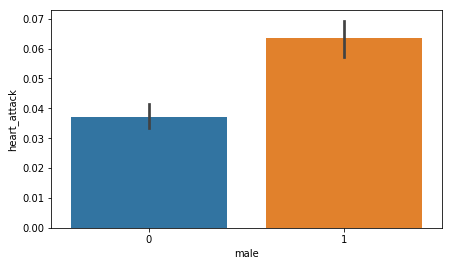

NULL count: 0
NULL perc: 0.0%


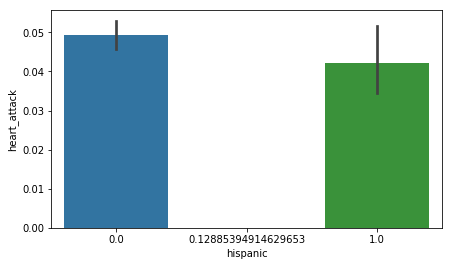

NULL count: 0
NULL perc: 0.0%


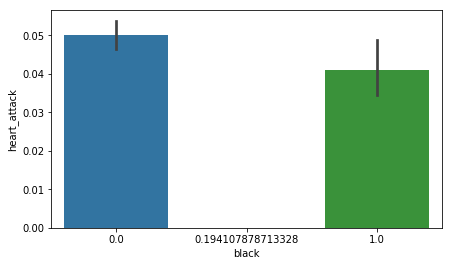

NULL count: 0
NULL perc: 0.0%


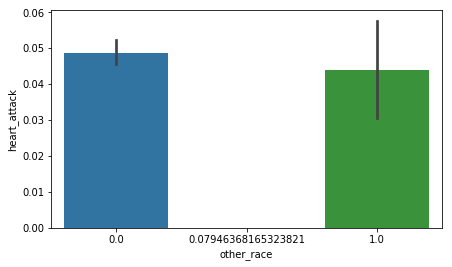

NULL count: 0
NULL perc: 0.0%


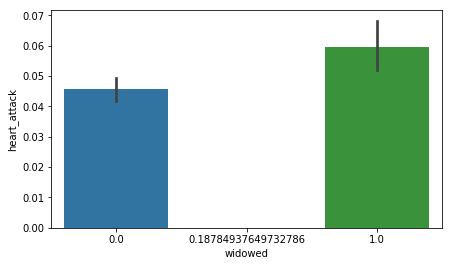

NULL count: 0
NULL perc: 0.0%


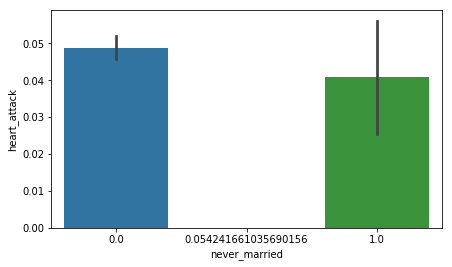

NULL count: 0
NULL perc: 0.0%


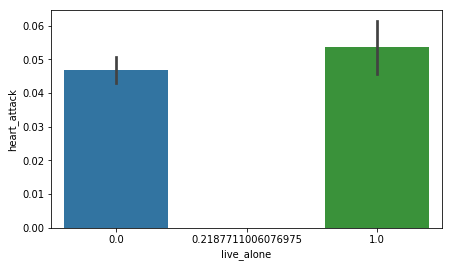

NULL count: 0
NULL perc: 0.0%


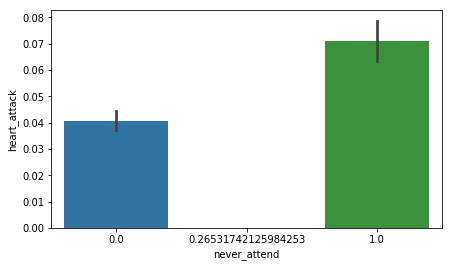

NULL count: 0
NULL perc: 0.0%


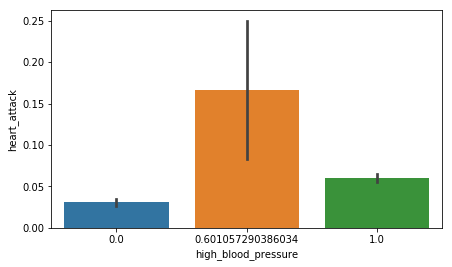

NULL count: 0
NULL perc: 0.0%


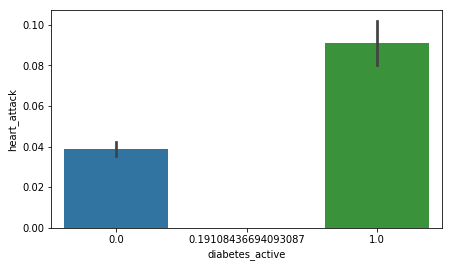

NULL count: 0
NULL perc: 0.0%


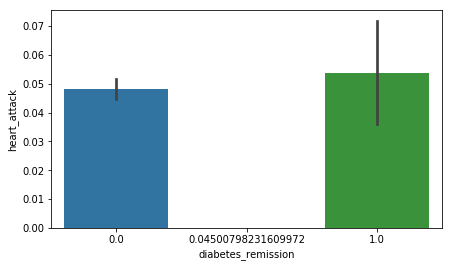

NULL count: 0
NULL perc: 0.0%


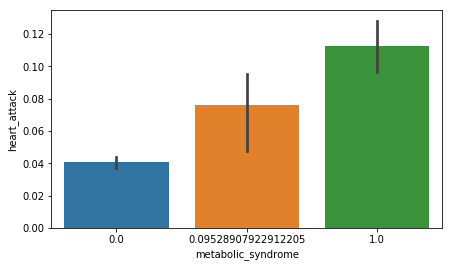

NULL count: 0
NULL perc: 0.0%


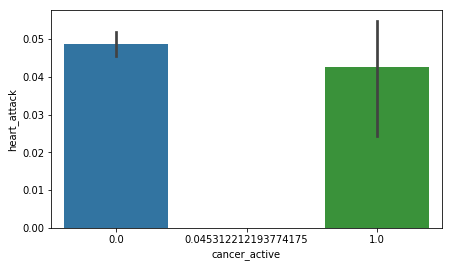

NULL count: 0
NULL perc: 0.0%


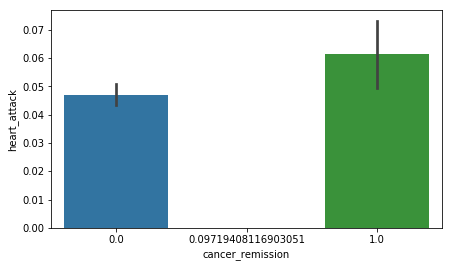

NULL count: 0
NULL perc: 0.0%


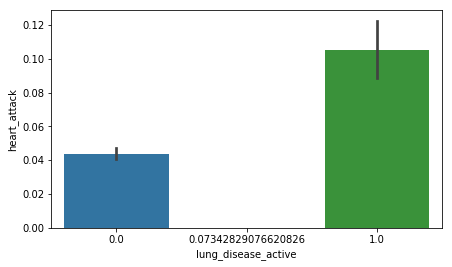

NULL count: 0
NULL perc: 0.0%


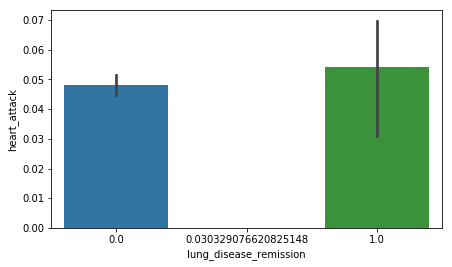

NULL count: 0
NULL perc: 0.0%


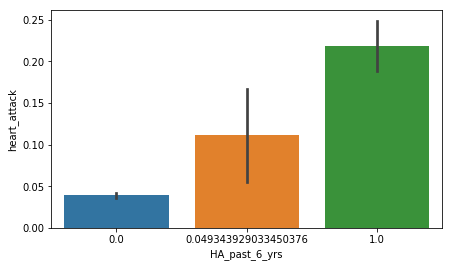

NULL count: 0
NULL perc: 0.0%


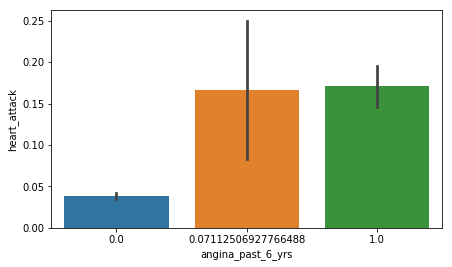

NULL count: 0
NULL perc: 0.0%


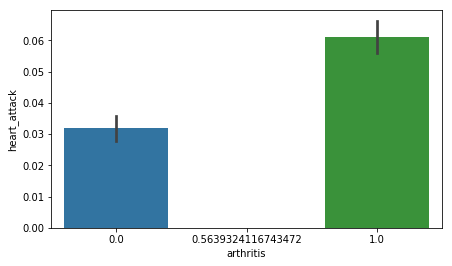

NULL count: 0
NULL perc: 0.0%


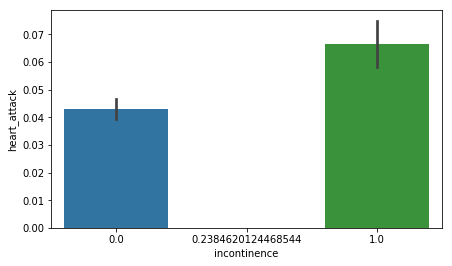

NULL count: 0
NULL perc: 0.0%


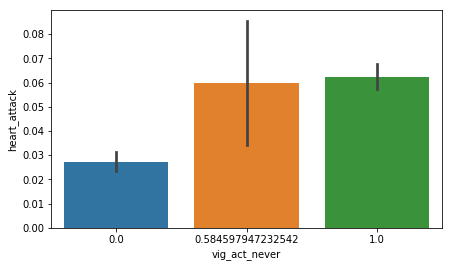

NULL count: 0
NULL perc: 0.0%


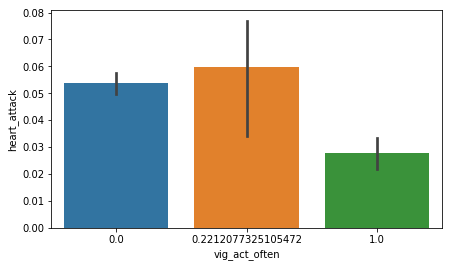

NULL count: 0
NULL perc: 0.0%


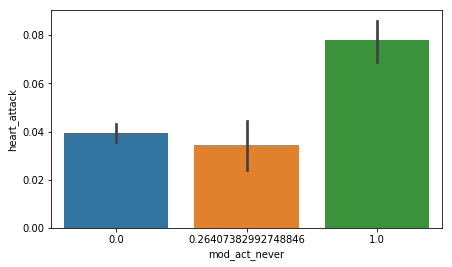

NULL count: 0
NULL perc: 0.0%


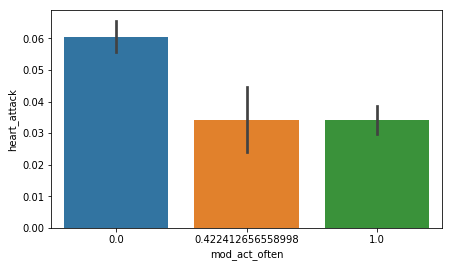

NULL count: 0
NULL perc: 0.0%


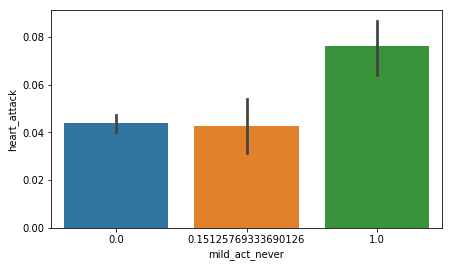

NULL count: 0
NULL perc: 0.0%


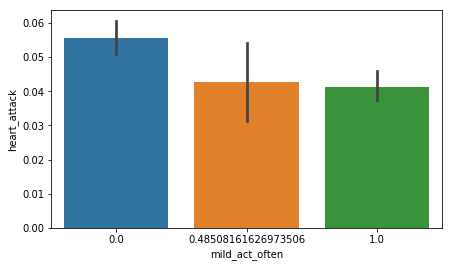

NULL count: 0
NULL perc: 0.0%


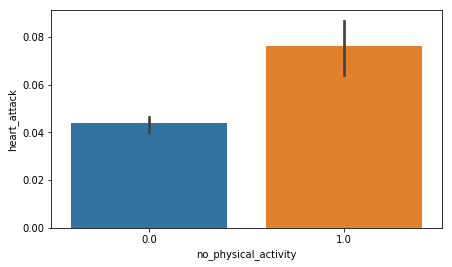

NULL count: 0
NULL perc: 0.0%


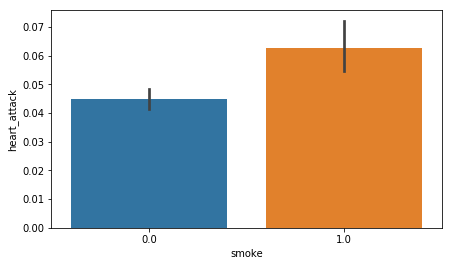

NULL count: 0
NULL perc: 0.0%


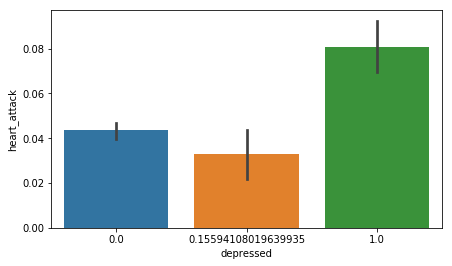

NULL count: 0
NULL perc: 0.0%


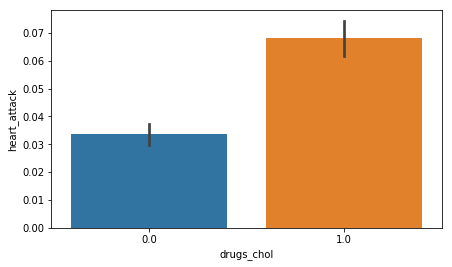

NULL count: 0
NULL perc: 0.0%


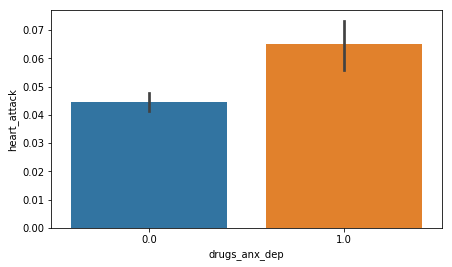

NULL count: 0
NULL perc: 0.0%


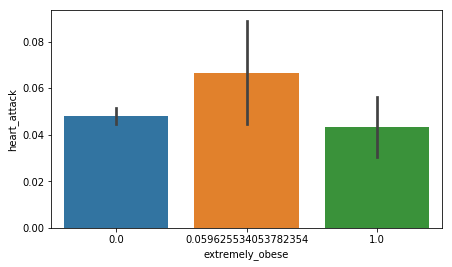

NULL count: 0
NULL perc: 0.0%


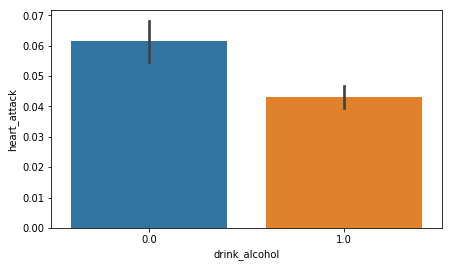

NULL count: 0
NULL perc: 0.0%


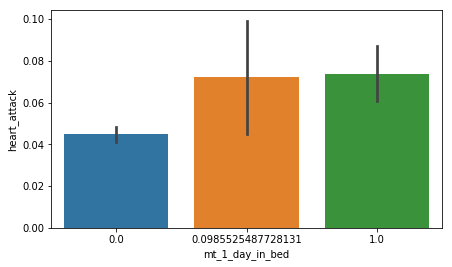

In [23]:
# Bar plots for categorical IVs
for iv in cat_ivs2:
    plt.figure(figsize=(7, 4))
    print('NULL count:', xtest5[iv].isnull().sum())
    print('NULL perc: ' + str(round(xtest5[iv].isnull().sum() / len(xtest5) * 100, 1)) + '%')
    sns.barplot(x=iv, y="heart_attack", data=xtest5, ci=68)
    plt.show()
    print('=' * 100)

### Model Comparison Benchmark 1:  All Classified One Way

Because only about 5% of respondents had a heart attack in the 6-year window, we could achieve 95% accuracy simply by predicting that NO ONE had a heart attack within the 6 years.

In [29]:
print(xtrain5['heart_attack'].value_counts(dropna=False))
xtrain5['heart_attack'].value_counts(dropna=False) / len(xtrain5)

0    15455
1      845
Name: heart_attack, dtype: int64


0    0.94816
1    0.05184
Name: heart_attack, dtype: float64

In [30]:
print(xtest['heart_attack'].value_counts(dropna=False))
xtest['heart_attack'].value_counts(dropna=False) / len(xtest)

0    3879
1     197
Name: heart_attack, dtype: int64


0    0.951668
1    0.048332
Name: heart_attack, dtype: float64

As expected, we would achieve ~95% (95.2%) accuracy by always predicting no heart attack (0).

However, this approach isn't very useful--it doesn't tell us anything about who may be at risk for a heart attack. 

### Model Comparison Benchmark 2:  Simple Logistic Regression Model

Fit a simple logistic regression model using the predictor variables above to predict who will have a heart attack.

Predicting heart attack (1) if the logistic regression score is >= 0.5.

In [26]:
# Use Scaled Data
log_reg_mod = sm.Logit(xtrain6['heart_attack'], add_constant(xtrain6[full_ivs]))
log_reg_result = log_reg_mod.fit(method='bfgs')
print(log_reg_result.summary())

         Current function value: 0.179674
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:           heart_attack   No. Observations:                16300
Model:                          Logit   Df Residuals:                    16260
Method:                           MLE   Df Model:                           39
Date:                Mon, 13 May 2019   Pseudo R-squ.:                  0.1188
Time:                        10:50:30   Log-Likelihood:                -2928.7
converged:                      False   LL-Null:                       -3323.6
                                        LLR p-value:                1.324e-140
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.2845      0.046    -70.

In [27]:
# Get the logistic regression model probability scores and predictions
log_reg_pred_scores = log_reg_result.predict(add_constant(xtest6[full_ivs]))
log_reg_pred = log_reg_pred_scores.round()

Accuracy: 0.9514229636898921
AUC: 0.7504367523682774
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3879
           1       0.43      0.02      0.03       197

   micro avg       0.95      0.95      0.95      4076
   macro avg       0.69      0.51      0.50      4076
weighted avg       0.93      0.95      0.93      4076



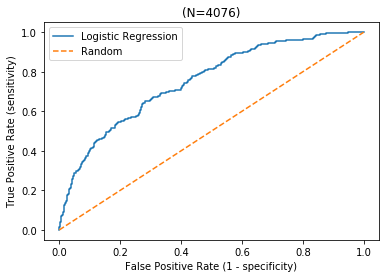

In [49]:
# Measure the performance of the classifier using several metrics
def measure_performance(actual, pred_scores):
    threshold = 0.5

#     print('Actual class distribution:')
#     print(actual.value_counts(dropna=False))
#     print('')
#     print('Predicted class distribution:')
#     print(((pred_scores >= threshold) * 1).value_counts(dropna=False))
#     print('-' * 50)
    
    print("Accuracy:", ((pred_scores >= threshold) * 1 == actual).mean())
    fpr, tpr, thresholds = metrics.roc_curve(actual, pred_scores)
    print("AUC:", metrics.auc(fpr, tpr))
    print(metrics.classification_report(actual, (pred_scores >= threshold) * 1))
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
    plt.xlabel('False Positive Rate (1 - specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title('(N=' + str(len(actual)) + ')')
    plt.legend()
    plt.show()
    
measure_performance(xtest6['heart_attack'], log_reg_pred_scores)

**Precision**:  % predicted as a class that were actually of that class

**Recall**:  % of a class that were correctly predicted to be of that class

**AUC**:  probability that the 1-coded class will have a higher score than a 0-coded class

Overall, in terms of accuracy, this model performs about the same (actually slightly worse) as just predicting that no one had a heart attack.  To do better, we must improve the model's ability to successfully identify the people that will have a heart attack (currently only 2% of heart attack victims were identified!).  Hopefully we can do better using a deep neural network!

# Deep Learning Model

In investigating different NN configurations, I relied on three metrics:  accuracy, sensitivity, and specificity.  Sensitivity is the proportion of heart attack cases that were correctly identified.  Specificity is the proportion of non-heart attack cases that were correctly identified.  It was important to consider sensitivity and specificity for this analysis due to the highly unbalanced distribution of classes (only ~5% of respondents had a heart attack in the 6-year period).  A model that is good at detecting people that will have a heart attack will have a high sensitivity.  Generally, there is a tradeoff between sensitivity and specificity.  The key will be to balance the two--detect as many heart attack cases as we can (maximize sensitivity) while also minimizing false alarms (minimizing 1-specificity).

In [44]:
# Metrics to track in addition to accuracy
# Source:  http://www.deepideas.net/unbalanced-classes-machine-learning/

# % of positive (1) class that was correctly classified as positive
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# % of negative (0) class that was correctly classified as negative
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

xtrain7 = xtrain6.sample(frac=1, random_state=1)

#### Model Incorporating Class Weights

Goal:  cause the model to pay more attention to the positive class (heart attack), which is more important to predict (within reason) than not having a heart attack.

(inspired by http://www.deepideas.net/unbalanced-classes-machine-learning/)

Train on 13040 samples, validate on 3260 samples
Epoch 1/50
13040/13040 [==============================] - 15s 1ms/step - loss: 1.0630 - acc: 0.7657 - sensitivity: 0.4856 - specificity: 0.7800 - val_loss: 1.1095 - val_acc: 0.8405 - val_sensitivity: 0.4367 - val_specificity: 0.8664
Epoch 2/50
13040/13040 [==============================] - 2s 136us/step - loss: 0.9803 - acc: 0.8028 - sensitivity: 0.5430 - specificity: 0.8170 - val_loss: 1.0710 - val_acc: 0.7727 - val_sensitivity: 0.5847 - val_specificity: 0.7854
Epoch 3/50
13040/13040 [==============================] - 2s 124us/step - loss: 0.9547 - acc: 0.8011 - sensitivity: 0.5669 - specificity: 0.8129 - val_loss: 1.0683 - val_acc: 0.7239 - val_sensitivity: 0.6213 - val_specificity: 0.7306
Epoch 4/50
13040/13040 [==============================] - 2s 117us/step - loss: 0.9405 - acc: 0.7849 - sensitivity: 0.6017 - specificity: 0.7940 - val_loss: 1.0779 - val_acc: 0.7696 - val_sensitivity: 0.5735 - val_specificity: 0.7826
Epoch 5/50
13040

Epoch 36/50
13040/13040 [==============================] - 1s 110us/step - loss: 0.3601 - acc: 0.9209 - sensitivity: 0.9227 - specificity: 0.9201 - val_loss: 2.8224 - val_acc: 0.8549 - val_sensitivity: 0.2578 - val_specificity: 0.8939
Epoch 37/50
13040/13040 [==============================] - 1s 109us/step - loss: 0.3419 - acc: 0.9250 - sensitivity: 0.9317 - specificity: 0.9244 - val_loss: 2.6512 - val_acc: 0.8239 - val_sensitivity: 0.3008 - val_specificity: 0.8567
Epoch 38/50
13040/13040 [==============================] - 1s 107us/step - loss: 0.3319 - acc: 0.9275 - sensitivity: 0.9419 - specificity: 0.9263 - val_loss: 2.9054 - val_acc: 0.8301 - val_sensitivity: 0.3230 - val_specificity: 0.8642
Epoch 39/50
13040/13040 [==============================] - 1s 107us/step - loss: 0.3296 - acc: 0.9271 - sensitivity: 0.9392 - specificity: 0.9263 - val_loss: 2.9189 - val_acc: 0.8304 - val_sensitivity: 0.2735 - val_specificity: 0.8665
Epoch 40/50
13040/13040 [==============================] - 1

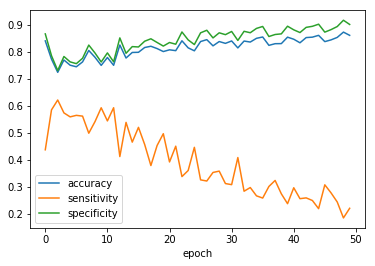

In [229]:
# Experiment with different model configurations using a 80-20 train-validation split

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=39, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.5))
#     model.add(Dense(100, input_dim=39, activation='relu', kernel_initializer='zeros',
#                    kernel_regularizer=regularizers.l2(0.)))
    model.add(Dense(10, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.75))
#     model.add(Dense(1000, activation='relu', kernel_initializer='zeros',
#                    kernel_regularizer=regularizers.l2(0.5)))
#     model.add(Dense(10, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.75))
#     model.add(Dense(1000, activation='relu', kernel_initializer='zeros',
#                    kernel_regularizer=regularizers.l2(0.5)))
#     model.add(Dense(10, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.75))
#     model.add(Dense(1000, activation='relu', kernel_initializer='normal',
#                    kernel_regularizer=regularizers.l1(0.5)))
#     model.add(Dense(10, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.75))
#     model.add(Dense(1000, activation='relu', kernel_initializer='normal',
#                    kernel_regularizer=regularizers.l1(0.5)))
#     model.add(Dense(10000, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.9))
#     model.add(Dense(10000, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.9))
#     model.add(Dense(10000, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.9))
#     model.add(Dense(10000, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.9))
#     model.add(Dense(10000, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.9))
#     model.add(Dense(10000, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.9))



    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', sensitivity, specificity])
    return model

modelx = create_model()
histx = modelx.fit(x=xtrain7[full_ivs], y=xtrain7['heart_attack'], batch_size=100, epochs=50, 
                   class_weight={0: 1.0, 1: 15.0}, verbose=1, validation_split=0.2)

plt.plot(histx.history['val_acc'], label='accuracy')
plt.plot(histx.history['val_sensitivity'], label='sensitivity')
plt.plot(histx.history['val_specificity'], label='specificity')
plt.xlabel('epoch')
plt.legend()
plt.show()

After selecting the "optimal" parameters via trial and error, determine the optimal number of epochs by fitting the model 10 times with different validation sets each time for 50 epochs and plot the average of each epoch.  Select the epoch that tends to optimally balance sensitivity and specificity.

In [230]:
# Fit the model with the above parameters 10 times and get the validation error each time
metric_log = {}

for i in range(10):
    print(i)
    modelx = create_model()
    histx = modelx.fit(x=xtrain7[full_ivs], y=xtrain7['heart_attack'], batch_size=100, epochs=50, 
                       class_weight={0: 1.0, 1: 15.0}, verbose=0, validation_split=0.2)

    metric_log[i] = {
        'val_acc': histx.history['val_acc'],
        'val_sensitivity': histx.history['val_sensitivity'],
        'val_specificity': histx.history['val_specificity'],
    }

0
1
2
3
4
5
6
7
8
9


In [239]:
# Combine the validation data for each of the 10 models in a way that can be analyzed and plotted
ml = pd.DataFrame({'val_acc_0': metric_log[0]['val_acc'], 'val_sensitivity_0': metric_log[0]['val_sensitivity'], 'val_specificity_0': metric_log[0]['val_specificity']})
for mod_num, mod_dat in metric_log.items():
    if mod_num != 0:
        for sec, dat in mod_dat.items():
            ml[sec + '_' + str(mod_num)] = dat
        
        
ml.head()

,val_acc_0,val_sensitivity_0,val_specificity_0,val_acc_1,val_sensitivity_1,val_specificity_1,val_acc_2,val_sensitivity_2,val_specificity_2,val_acc_3,...,val_specificity_6,val_acc_7,val_sensitivity_7,val_specificity_7,val_acc_8,val_sensitivity_8,val_specificity_8,val_acc_9,val_sensitivity_9,val_specificity_9
0,0.802147,0.476032,0.822582,0.735890,0.619510,0.744088,0.757055,0.578586,0.768687,0.711656,...,0.817096,0.772086,0.543566,0.786928,0.700614,0.655273,0.703969,0.726994,0.613667,0.735033
1,0.784969,0.511820,0.802459,0.765031,0.560753,0.778544,0.802147,0.512440,0.820655,0.749387,...,0.770288,0.753988,0.548118,0.767737,0.735890,0.603783,0.744645,0.762577,0.550309,0.776636
2,0.771472,0.578464,0.784487,0.771472,0.604574,0.784042,0.725153,0.661798,0.730737,0.723006,...,0.835375,0.749080,0.598780,0.761007,0.731902,0.587825,0.741662,0.738344,0.595372,0.748278
3,0.740491,0.625645,0.748270,0.767178,0.561082,0.780564,0.787730,0.519123,0.805111,0.778221,...,0.743015,0.777301,0.546840,0.792504,0.805521,0.487280,0.826051,0.796933,0.526938,0.815137
4,0.777607,0.568787,0.791359,0.736196,0.642772,0.742699,0.739264,0.657464,0.746702,0.705521,...,0.805632,0.780675,0.530334,0.797179,0.728221,0.615469,0.737181,0.739571,0.571197,0.751555


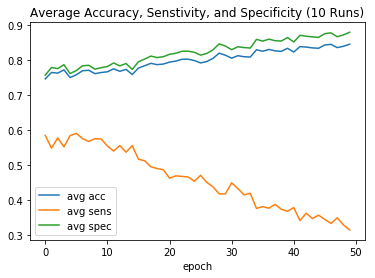

In [244]:
# Plot the validation accuracy, sensitivity, and specificity with respect to epoch
acc_col = [col for col in ml.columns if 'acc' in col]
sensitivity_col = [col for col in ml.columns if 'sensitivity' in col]
specificity_col = [col for col in ml.columns if 'specificity' in col]

acc_avg = ml[acc_col].mean(axis=1)
sensitivity_avg = ml[sensitivity_col].mean(axis=1)
specificity_avg = ml[specificity_col].mean(axis=1)

plt.plot(acc_avg, label='avg acc')
plt.plot(sensitivity_avg, label='avg sens')
plt.plot(specificity_avg, label='avg spec')
plt.xlabel('epoch')
plt.title('Average Accuracy, Senstivity, and Specificity (10 Runs)')
plt.legend()
plt.show()

In [243]:
pd.DataFrame({'acc_avg': acc_avg, 'sens_avg': sensitivity_avg, 'spec_avg': specificity_avg})

,acc_avg,sens_avg,spec_avg
0,0.746564,0.584923,0.757147
1,0.764755,0.548941,0.778863
2,0.762945,0.578025,0.775757
3,0.772147,0.552595,0.786842
4,0.750276,0.584789,0.761592
5,0.758252,0.590989,0.770215
6,0.769724,0.576210,0.783810
7,0.771043,0.567912,0.785201
8,0.761319,0.576023,0.774329
9,0.764632,0.574897,0.778373


The optimal balance appears to be around 5 epochs, with ~57% sensitivity and ~77% specificity.  That is the final model I will go with.

### Train Full Model

Final Model Specifications:
- Predictor variables: 39
- 2 hidden layers:
    - Hidden layer 1:  100 neurons, relu activation, Gaussian weight initialization (Keras default Gaussian)
    - Hidden layer 2:  10 neurons, relu activation, Gassian weight initialization
- Output layer:  1 neuron (for binary classification), sigmoid activation
- Loss function:  binary cross entropy
- Optimizer:  Adam
- Batch size:  100
- Epochs:  5
- Class weights:  0: 1, 1: 15 (person having a heart attack is given 15x the weight of a person not having a heart attack)
- All other parameters are the default for Keras 2.2.4

In [45]:
# Create the final model and train it on the full training set
def create_final_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=39, activation='relu', kernel_initializer='normal'))
    model.add(Dense(10, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', sensitivity, specificity])
    return model

final_model = create_final_model()
hist_final = final_model.fit(x=xtrain7[full_ivs], y=xtrain7['heart_attack'], batch_size=100, epochs=5, 
                   class_weight={0: 1.0, 1: 15.0}, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
16300/16300 [==============================] - 1s 43us/step - loss: 1.0714 - acc: 0.7055 - sensitivity: 0.6008 - specificity: 0.7126
Epoch 2/5
16300/16300 [==============================] - 0s 15us/step - loss: 0.9951 - acc: 0.7648 - sensitivity: 0.5997 - specificity: 0.7739
Epoch 3/5
16300/16300 [==============================] - 0s 16us/step - loss: 0.9742 - acc: 0.7694 - sensitivity: 0.6093 - specificity: 0.7786
Epoch 4/5
16300/16300 [==============================] - 0s 16us/step - loss: 0.9569 - acc: 0.7742 - sensitivity: 0.6128 - specificity: 0.7822
Epoch 5/5
16300/16300 [==============================] - 0s 19us/step - loss: 0.9436 - acc: 0.7832 - sensitivity: 0.6328 - specificity: 0.7914


### Measure the Performance of the Final Model on the Test Data

In [46]:
# Measure the performance of the final model on the test data
final_pred = final_model.predict(xtest6[full_ivs])
final_pred

array([[0.15393284],
       [0.23259723],
       [0.20051533],
       ...,
       [0.18121123],
       [0.2347304 ],
       [0.35218737]], dtype=float32)

Accuracy: 0.7659470068694799
AUC: 0.7517636943950439
              precision    recall  f1-score   support

           0       0.97      0.78      0.86      3879
           1       0.12      0.58      0.19       197

   micro avg       0.77      0.77      0.77      4076
   macro avg       0.54      0.68      0.53      4076
weighted avg       0.93      0.77      0.83      4076



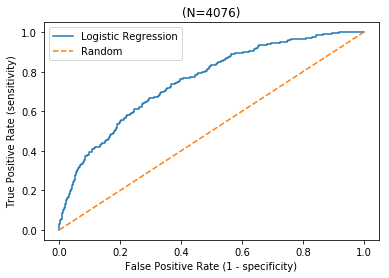

In [50]:
measure_performance(xtest6['heart_attack'], final_pred.reshape(1, -1)[0])

Overall, the NN model has lower overall accuracy and lower specificity than the logistic regression model, but it also has much higher sensitivity, making it more useful for actually detecting people that will have a heart attack. 

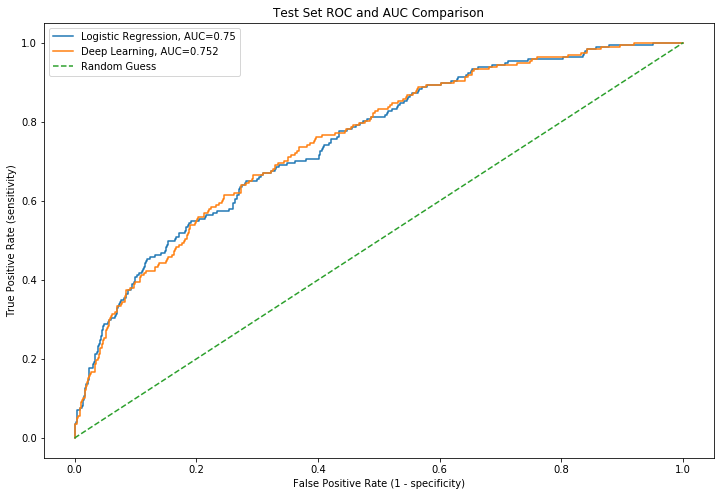

In [54]:
fpr_log_reg, tpr_log_reg, thresholds_log_reg = metrics.roc_curve(xtest6['heart_attack'], log_reg_pred_scores)
auc_log_reg = metrics.auc(fpr_log_reg, tpr_log_reg)

fpr_dl, tpr_dl, thresholds_dl = metrics.roc_curve(xtest6['heart_attack'], final_pred.reshape(1, -1)[0])
auc_dl = metrics.auc(fpr_dl, tpr_dl)

plt.figure(figsize=(12, 8))
plt.plot(fpr_log_reg, tpr_log_reg, label='Logistic Regression, AUC=' + str(round(auc_log_reg, 3)))
plt.plot(fpr_dl, tpr_dl, label='Deep Learning, AUC=' + str(round(auc_dl, 3)))
plt.plot([0, 1], [0, 1], label='Random Guess', linestyle='--')
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (sensitivity)')
plt.title('Test Set ROC and AUC Comparison')
plt.legend()
plt.show()